In [2]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import astropy.cosmology as apc
from sphviewer.tools import QuickView
from sphviewer.tools import Blend

In [3]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [4]:
pl.rc('font', size = 28)
pl.rc('legend', fontsize = 28)
pl.rc('axes', linewidth=1.5)
#sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
#trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')
sim = h5py.File('/disk1/lbignone/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/lbignone/data/cielo/simulations/LG1/LG1_tree.dat')

In [10]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [11]:
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
TdayTotalStars = sim['SnapNumber_128/PartType4/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [12]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, zlist = [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            # now we keep only theones between r_optical
            
            rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
            
            posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
            posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            
            xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
            rr = np.sqrt(xx**2+yy**2+zz**2)
            
            ik = np.where(rr<rop)[0]
            
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            tempIds = tempIds[ik]
            
            Idlist.extend(list(tempIds))
            zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            zlist.extend([zs]*tempIds.size)
            

    Idlist = np.array(Idlist)
    zlist = np.array(zlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    zlist = zlist[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
    posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
    rr = np.sqrt(xx**2+yy**2+zz**2)
            
    ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    zorder = np.zeros(IndexT_.size)
    zorder[is1] = zlist_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
    LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
    icut2 = np.where(LostNow==-1)[0]
    IndexT_near_ = IndexT_near[icut2]
        
    zorder_ = zorder[icut2]   
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near_]

    # WARNING, dangerous replacement
#     temporder_near = sim['SnapNumber_128/PartType0/StarFormationRate'][IndexT_near]
    #END WARNING
    
#     IE0 = sim['SnapNumber_128/PartType0/InternalEnergy'][IndexT_near]
#     ne10 = sim['SnapNumber_128/PartType0/ElectronAbundance'][IndexT_near]
#     t0 = tempFromMass(GasMasses, GassAbundances, IE0, ne10)
    
#     temporder_near = temporder_near - t0
#     temporder_near = t0 # not so subtle replacement
    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]
    
    return X, Y, Z, zorder_

def getAllLastPStars(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at the maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            
            rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
            
            posPart = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
            posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            
            xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
            rr = np.sqrt(xx**2+yy**2+zz**2)
            
            ik = np.where(rr<rop)[0]
            
            tempIds = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            tempIds = tempIds[ik]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalStars, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
            
    posPart = sim['SnapNumber_128/PartType4/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
            
    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
    rr = np.sqrt(xx**2+yy**2+zz**2)
            
    ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType4/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    TdayIDs = TdayIDs[ik]
    
    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalStars, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
    LostNow = sim['SnapNumber_128/PartType4/SubGroupNumber'][IndexT_near]
    
    icut2 = np.where(LostNow==-1)[0]
    IndexT_near_ = IndexT_near[icut2]
        
    NearCoord = sim['SnapNumber_128/PartType4/Coordinates'][IndexT_near_]

    # WARNING, dangerous replacement
#     temporder_near = sim['SnapNumber_128/PartType0/StarFormationRate'][IndexT_near]
    #END WARNING
    
#     IE0 = sim['SnapNumber_128/PartType0/InternalEnergy'][IndexT_near]
#     ne10 = sim['SnapNumber_128/PartType0/ElectronAbundance'][IndexT_near]
#     t0 = tempFromMass(GasMasses, GassAbundances, IE0, ne10)
    
#     temporder_near = temporder_near - t0
#     temporder_near = t0 # not so subtle replacement
    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]
    
    return X, Y, Z

In [7]:
gal, cen = 4470, 4469 

X, Y, Z, zorder = getAllLastP(gal, cen)
Xsl, Ysl, Zsl = getAllLastPStars(gal, cen)

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
offDMgro = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

pos = posGal -posCen

posDM = sim['SnapNumber_128/PartType1/Coordinates'][offDMgro[0]:offDMgro[1]]
Xg, Yg, Zg = posDM[:,0] - posCen[0], posDM[:,1] - posCen[1], posDM[:,2] - posCen[2]
r = np.sqrt(Xg**2+Yg**2.+Zg**2.)
rmax = r.max()

posDMtot = sim['SnapNumber_128/PartType1/Coordinates'][()]
Xgg, Ygg, Zgg = posDMtot[:,0] - posCen[0], posDMtot[:,1] - posCen[1], posDMtot[:,2] - posCen[2]
rr = np.sqrt(Xgg**2+Ygg**2.+Zgg**2.)
i = np.where(rr<rmax)

Xg, Yg, Zg = Xgg[i], Ygg[i], Zgg[i]

offstar = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
PoStar = sim['SnapNumber_128/PartType4/Coordinates'][offstar[0]:offstar[1]]
xS, yS, zS = PoStar[:,0] - posCen[0], PoStar[:,1] - posCen[1], PoStar[:,2] - posCen[2]


velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal- velCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

newP = np.array([Xg, Yg, Zg]).T

XR, YR, ZR = [], [], []

for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
    XR.append(dV[0])
    YR.append(dV[1])
    ZR.append(dV[2])
    
XR, YR, ZR = np.array(XR), np.array(YR), np.array(ZR)

XRS, YRS, ZRS = [], [], []
for x, y, z in zip(xS, yS, zS):
    dV = np.matmul(RM, np.array([x, y, z]))
    XRS.append(dV[0])
    YRS.append(dV[1])
    ZRS.append(dV[2])
    
XRS, YRS, ZRS = np.array(XRS), np.array(YRS), np.array(ZRS)


XRL, YRL, ZRL = [], [], []
for x, y, z in zip(Xsl, Ysl, Zsl):
    dV = np.matmul(RM, np.array([x, y, z]))
    XRL.append(dV[0])
    YRL.append(dV[1])
    ZRL.append(dV[2])
    
XRL, YRL, ZRL = np.array(XRL), np.array(YRL), np.array(ZRL)

newPR = []
for v in newP:
    dV = np.matmul(RM, v)
       
    newPR.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x
    
newPR = np.array(newPR)

# and the orbit

xo, yo, zo = [], [], []

uniqueID = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+cen)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
   
xM, yM, zM = 0, 0, 0  
for mm, mmC in zip(mtree, mtreeC): # ignore the first one
    snap, idd = split_unique_id(int(mm))
    snapC, iddC = split_unique_id(int(mmC))
    
    pg = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    pc = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    
    ps = pg - pc
    xo.append(ps[0])
    yo.append(ps[1])
    zo.append(ps[2])
    
    if snap==101:
        xM, yM, zM = ps[0], ps[1], ps[2]
    
xo, yo, zo = np.array(xo), np.array(yo), np.array(zo)


xor, yor, zor = [], [], []
for x, y, z in zip(xo, yo, zo):
    dV = np.matmul(RM, np.array([x, y, z]))
    xor.append(dV[0])
    yor.append(dV[1])
    zor.append(dV[2])
    
xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)

mrot = np.matmul(RM, np.array([xM, yM, zM]))

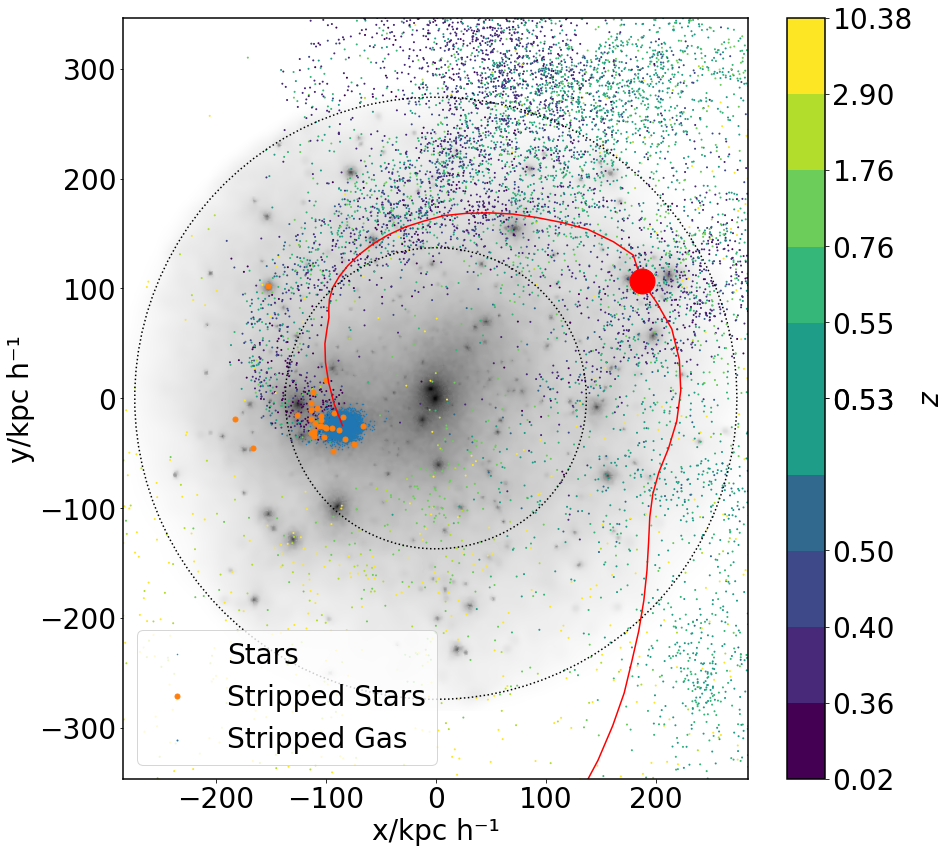

In [8]:
fig, ax = pl.subplots(figsize=(14,14))

pp = np.linspace(0, 100, 11)
vv = np.percentile(zorder, pp)
norm = mpc.BoundaryNorm(boundaries=vv, ncolors=256)

pl.scatter(YR, ZR, s=1, label='Stripped Gas', c=zorder, norm=norm)
# pl.scatter(YRS, ZRS, s=1, label='Stars')
# pl.scatter(YRL, ZRL, s=30, label='Stripped Stars')
pl.plot(YRS, ZRS, marker='o', label='Stars', ls=' ', markersize=0.5)
pl.plot(YRL, ZRL, label='Stripped Stars',marker='o', ls=' ', markersize=5)

#pl.scatter(0., 0., color='black')

bar = pl.colorbar(label='$z$')
bar.set_ticks(vv)

pl.legend(loc='best')

pl.plot(yor, zor, ls='-', color='red')

t = np.linspace(0., 2.*np.pi, 100)
x0, y0 = r200*np.cos(t), r200*np.sin(t)
    
pl.plot(x0, y0, ls=':', color='black')
pl.plot(2*x0, 2*y0, ls=':', color='black')
# pl.scatter(mrot[1], mrot[2], marker='o', color='red', s=500)
pl.plot(mrot[1], mrot[2], marker='o', color='red', ls=' ', markersize=25)

pl.xlabel('x/kpc h⁻¹')
pl.ylabel('y/kpc h⁻¹')

pl.axis('equal')
qv = QuickView(newPR, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r')

In [9]:
def plotTheGal(gal, cen):

    X, Y, Z, zorder = getAllLastP(gal, cen)
    Xsl, Ysl, Zsl = getAllLastPStars(gal, cen)

    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
    offDMgro = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

    
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    pos = posGal -posCen

    posDM = sim['SnapNumber_128/PartType1/Coordinates'][offDMgro[0]:offDMgro[1]]
    Xg, Yg, Zg = posDM[:,0] - posCen[0], posDM[:,1] - posCen[1], posDM[:,2] - posCen[2]
    r = np.sqrt(Xg**2+Yg**2.+Zg**2.)
    rmax = r.max()

    posDMtot = sim['SnapNumber_128/PartType1/Coordinates'][()]
    Xgg, Ygg, Zgg = posDMtot[:,0] - posCen[0], posDMtot[:,1] - posCen[1], posDMtot[:,2] - posCen[2]
    rr = np.sqrt(Xgg**2+Ygg**2.+Zgg**2.)
    i = np.where(rr<rmax)

    Xg, Yg, Zg = Xgg[i], Ygg[i], Zgg[i]

    offstar = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    PoStar = sim['SnapNumber_128/PartType4/Coordinates'][offstar[0]:offstar[1]]
    xS, yS, zS = PoStar[:,0] - posCen[0], PoStar[:,1] - posCen[1], PoStar[:,2] - posCen[2]


    velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

    vel = velGal- velCen

    h = np.cross(pos, vel)
    h = h/np.sqrt(np.sum(h**2.))

    f = (1-h[0])/(h[1]**2 + h[2]**2)
    R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
    R2 = np.matmul(R1, R1)

    RM = np.identity(3) + R1 + R2*f

    newP = np.array([Xg, Yg, Zg]).T

    XR, YR, ZR = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RM, np.array([x, y, z]))
        XR.append(dV[0])
        YR.append(dV[1])
        ZR.append(dV[2])

    XR, YR, ZR = np.array(XR), np.array(YR), np.array(ZR)

    XRS, YRS, ZRS = [], [], []
    for x, y, z in zip(xS, yS, zS):
        dV = np.matmul(RM, np.array([x, y, z]))
        XRS.append(dV[0])
        YRS.append(dV[1])
        ZRS.append(dV[2])

    XRS, YRS, ZRS = np.array(XRS), np.array(YRS), np.array(ZRS)


    XRL, YRL, ZRL = [], [], []
    for x, y, z in zip(Xsl, Ysl, Zsl):
        dV = np.matmul(RM, np.array([x, y, z]))
        XRL.append(dV[0])
        YRL.append(dV[1])
        ZRL.append(dV[2])

    XRL, YRL, ZRL = np.array(XRL), np.array(YRL), np.array(ZRL)

    newPR = []
    for v in newP:
        dV = np.matmul(RM, v)

        newPR.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x

    newPR = np.array(newPR)

    # and the orbit

    xo, yo, zo = [], [], []

    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))

    uniqueIDC = int(128*1e6+cen)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

    for mm, mmC in zip(mtree, mtreeC): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))

        pg = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        pc = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]

        ps = pg - pc
        xo.append(ps[0])
        yo.append(ps[1])
        zo.append(ps[2])

    xo, yo, zo = np.array(xo), np.array(yo), np.array(zo)


    xor, yor, zor = [], [], []
    for x, y, z in zip(xo, yo, zo):
        dV = np.matmul(RM, np.array([x, y, z]))
        xor.append(dV[0])
        yor.append(dV[1])
        zor.append(dV[2])

    xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)
    
    fig, ax = pl.subplots(figsize=(14,14))

    pp = np.linspace(0, 100, 11)
    vv = np.percentile(zorder, pp)
    norm = mpc.BoundaryNorm(boundaries=vv, ncolors=256)
    
#     pl.scatter(YR, ZR, s=1, label='Stripped Gas')
#     pl.scatter(YRS, ZRS, s=1, label='Stars')
#     pl.scatter(YRL, ZRL, s=30, label='Stripped Stars')
    #pl.scatter(0., 0., color='black')
    
    pl.scatter(YR, ZR, s=1, label='Stripped Gas', c=zorder, norm=norm)
    # pl.scatter(YRS, ZRS, s=1, label='Stars')
    # pl.scatter(YRL, ZRL, s=30, label='Stripped Stars')
    pl.plot(YRS, ZRS, marker='o', label='Stars', ls=' ', markersize=0.5)
    pl.plot(YRL, ZRL, label='Stripped Stars',marker='o', ls=' ', markersize=5)

    #pl.scatter(0., 0., color='black')

    bar = pl.colorbar(label='$z$')
    bar.set_ticks(vv)
    
    t = np.linspace(0., 2.*np.pi, 100)
    x0, y0 = r200*np.cos(t), r200*np.sin(t)
    
    pl.plot(x0, y0, ls=':', color='black')
    pl.plot(2*x0, 2*y0, ls=':', color='black')

    pl.legend(loc='best')

    pl.plot(yor, zor, ls='-', color='red')

    pl.xlabel('x/kpc h⁻¹')
    pl.ylabel('y/kpc h⁻¹')

    pl.axis('equal')
    qv = QuickView(newPR, r='infinity', plot=False)
    qv.imshow(cmap='gist_gray_r')

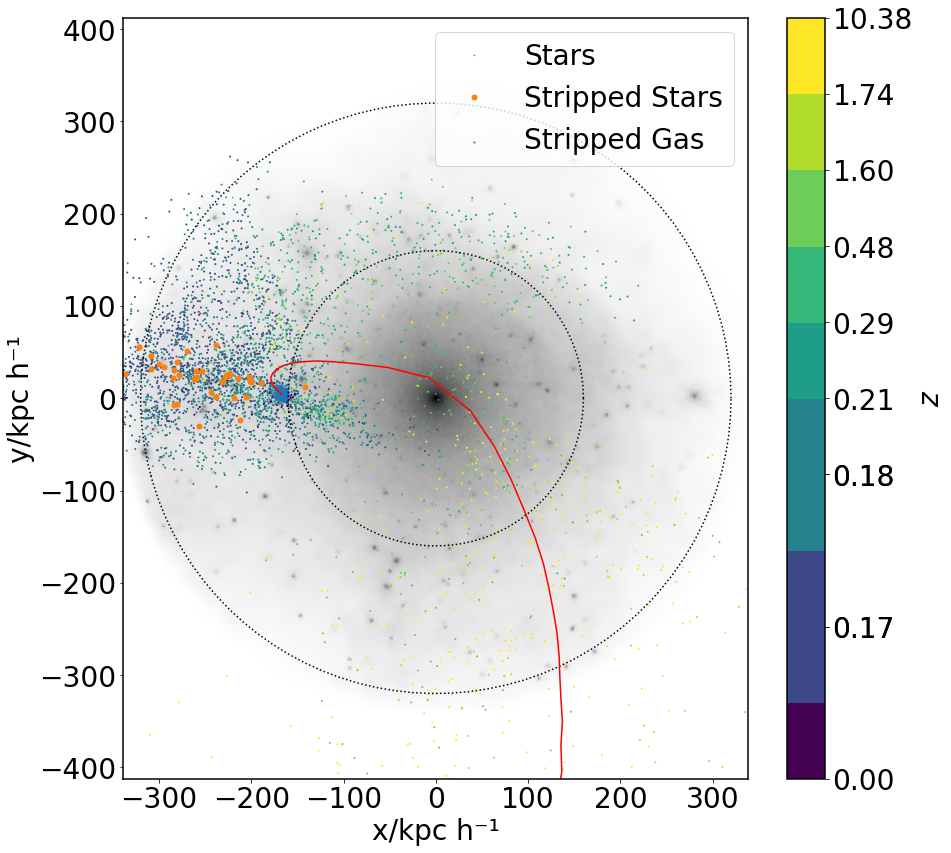

In [10]:
plotTheGal(4338, 4337)

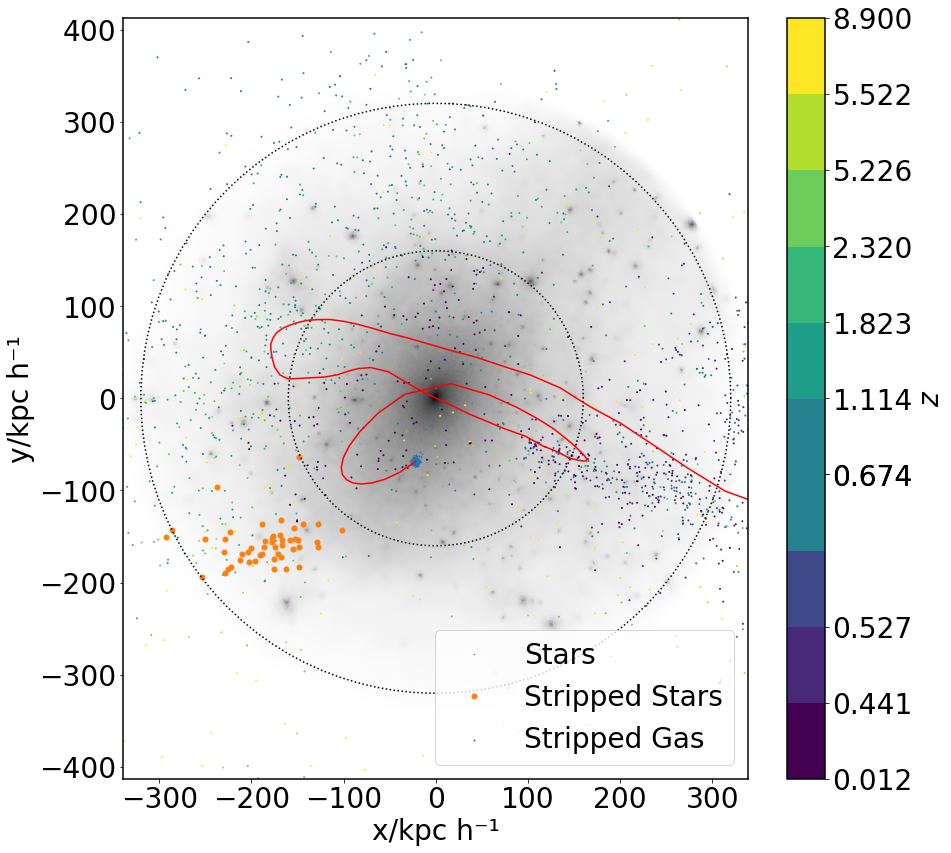

In [11]:
plotTheGal(4339, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


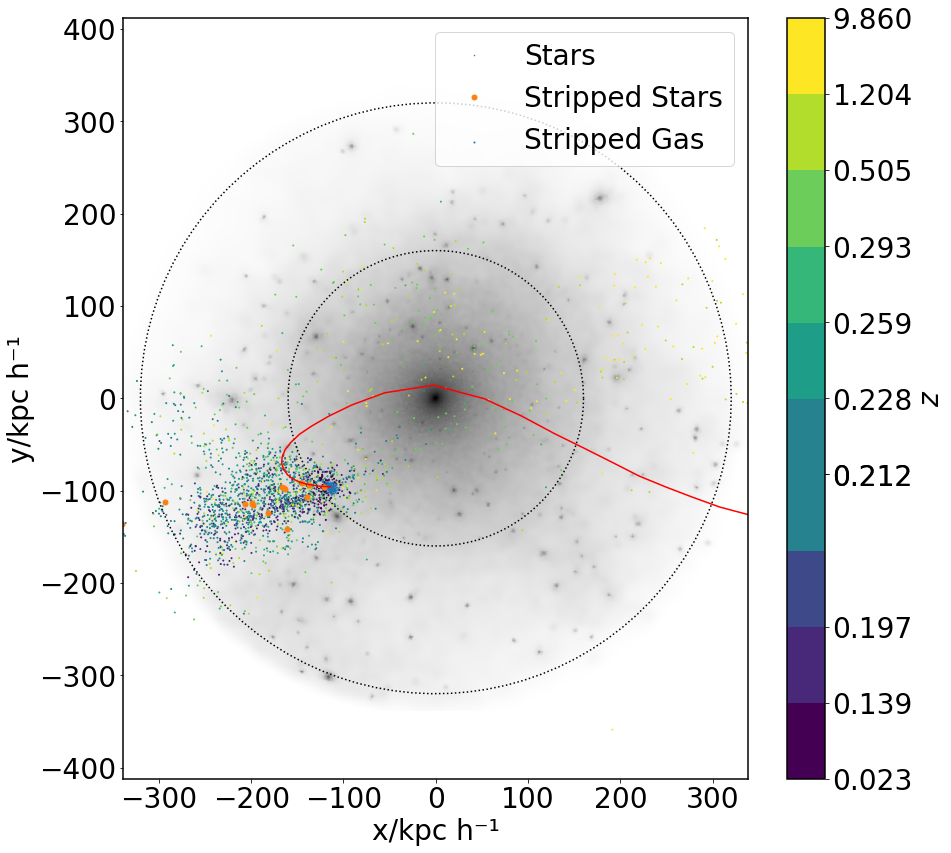

In [12]:
plotTheGal(4341, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


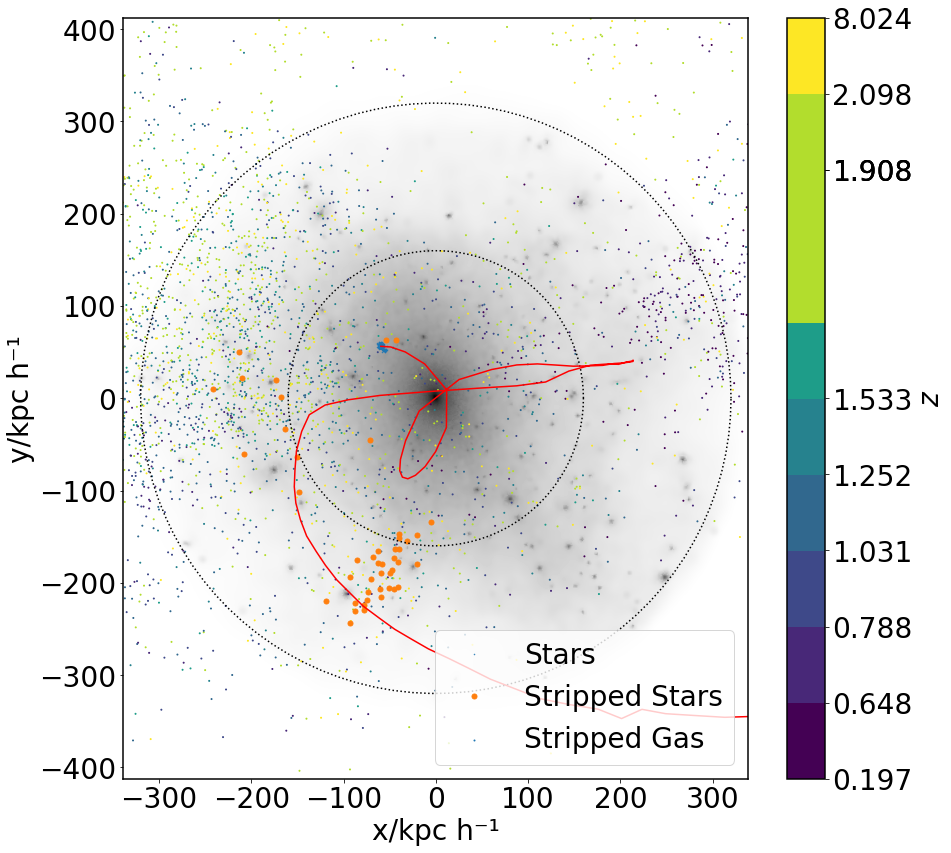

In [13]:
plotTheGal(4343, 4337)

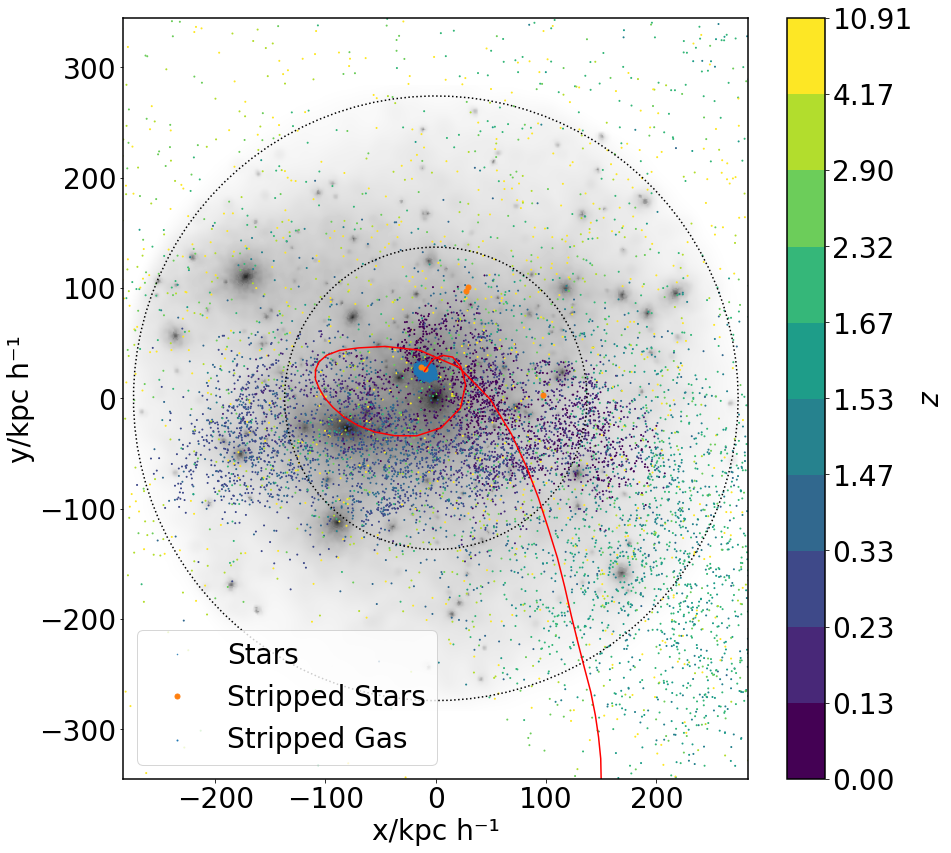

In [14]:
plotTheGal(4471, 4469)

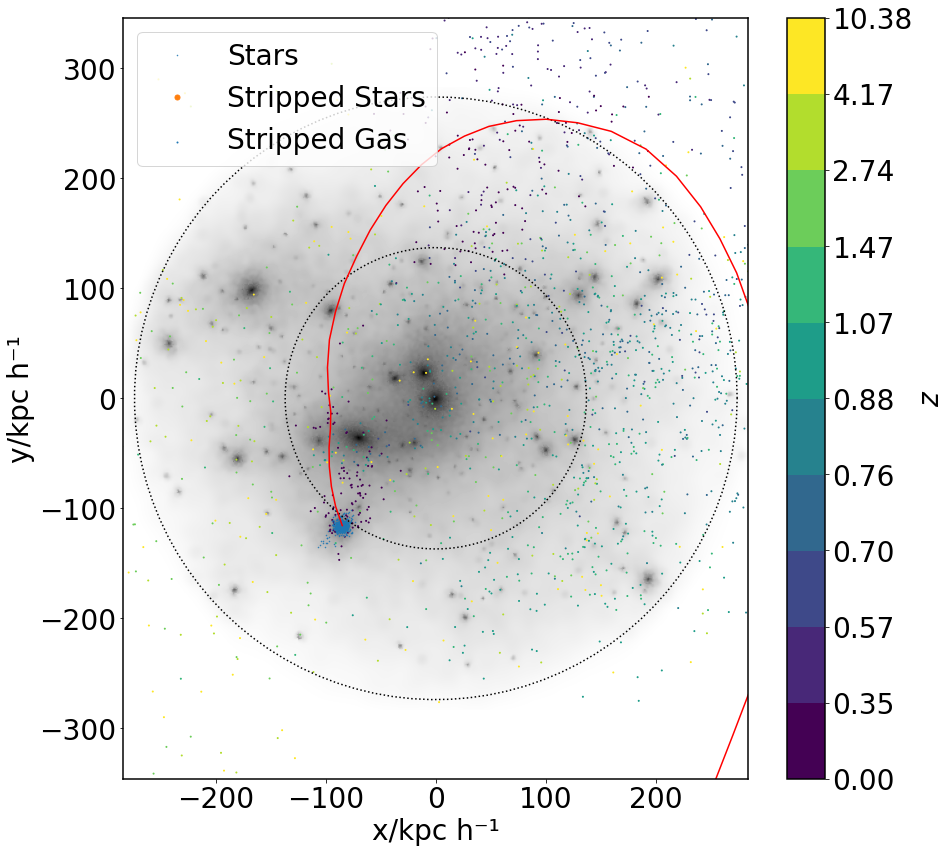

In [15]:
plotTheGal(4473, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


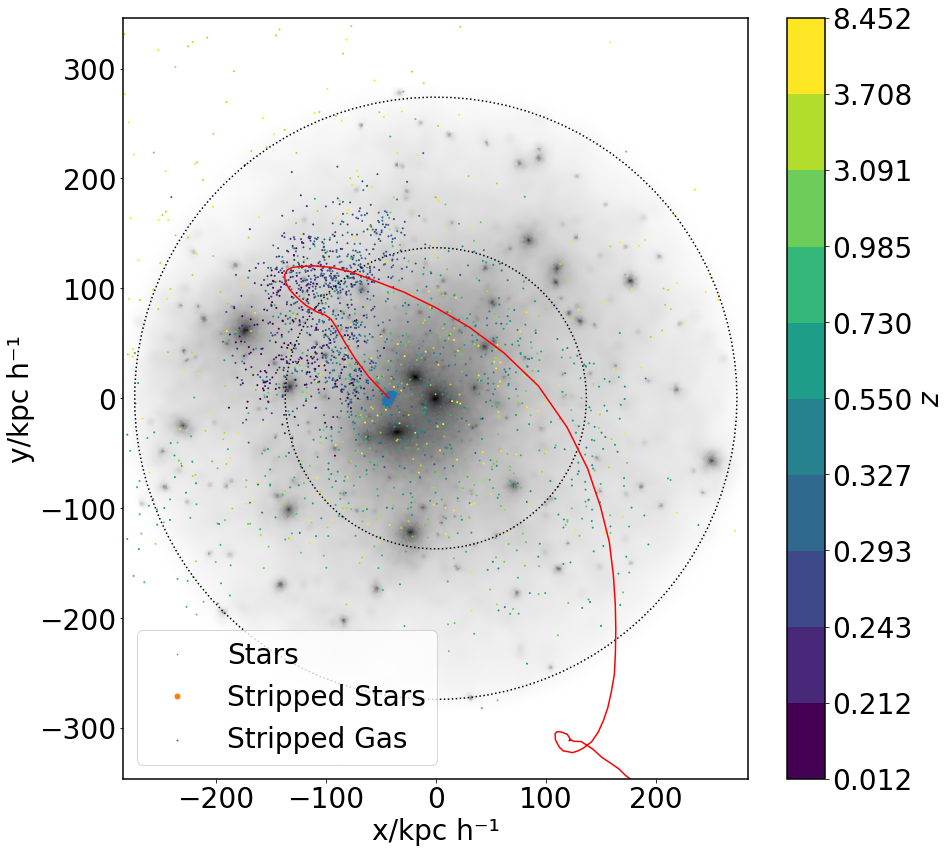

In [16]:
plotTheGal(4474, 4469)

In [13]:
def getAllLastP_unlimited(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, zlist = [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            # now we keep only theones between r_optical
            
            #rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
            
#             posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
#             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            
#             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
#             rr = np.sqrt(xx**2+yy**2+zz**2)
            
#             ik = np.where(rr<rop)[0]
            
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             tempIds = tempIds[ik]
            Idlist.extend(list(tempIds))
            zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            zlist.extend([zs]*tempIds.size)
        
    Idlist = np.array(Idlist)
    zlist = np.array(zlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    zlist = zlist[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
#     rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
            
#     posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
            
#     xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
#     rr = np.sqrt(xx**2+yy**2+zz**2)
            
#     ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
#     TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    zorder = np.zeros(IndexT_.size)
    zorder[is1] = zlist_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0]
#     IndexT_near_ = IndexT_near[icut2]
        
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]

    # WARNING, dangerous replacement
#     temporder_near = sim['SnapNumber_128/PartType0/StarFormationRate'][IndexT_near]
    #END WARNING
    
#     IE0 = sim['SnapNumber_128/PartType0/InternalEnergy'][IndexT_near]
#     ne10 = sim['SnapNumber_128/PartType0/ElectronAbundance'][IndexT_near]
#     t0 = tempFromMass(GasMasses, GassAbundances, IE0, ne10)
    
#     temporder_near = temporder_near - t0
#     temporder_near = t0 # not so subtle replacement
    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]
    
    return X, Y, Z, zorder

def getAllLastPStars_unlimited(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            # now we keep only theones between r_optical
            
            rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
            
            posPart = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
            posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            
            xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
            rr = np.sqrt(xx**2+yy**2+zz**2)
            
            ik = np.where(rr<rop)[0]
            
            tempIds = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            tempIds = tempIds[ik]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalStars, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
            
    posPart = sim['SnapNumber_128/PartType4/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
            
    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
    rr = np.sqrt(xx**2+yy**2+zz**2)
            
    ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType4/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    TdayIDs = TdayIDs[ik]
    
    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalStars, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType4/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0]
#     IndexT_near_ = IndexT_near[icut2]
        
    NearCoord = sim['SnapNumber_128/PartType4/Coordinates'][IndexT_near]

    # WARNING, dangerous replacement
#     temporder_near = sim['SnapNumber_128/PartType0/StarFormationRate'][IndexT_near]
    #END WARNING
    
#     IE0 = sim['SnapNumber_128/PartType0/InternalEnergy'][IndexT_near]
#     ne10 = sim['SnapNumber_128/PartType0/ElectronAbundance'][IndexT_near]
#     t0 = tempFromMass(GasMasses, GassAbundances, IE0, ne10)
    
#     temporder_near = temporder_near - t0
#     temporder_near = t0 # not so subtle replacement
    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]
    
    return X, Y, Z

In [38]:
def plotTheGal_cen(gal, cen):

    X, Y, Z, zorder = getAllLastP_unlimited(gal, cen)
#     Xsl, Ysl, Zsl = getAllLastPStars_unlimited(gal, cen)

    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
    offDMgro = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

    
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    pos = posGal -posCen

    posDM = sim['SnapNumber_128/PartType1/Coordinates'][offDMgro[0]:offDMgro[1]]
    Xg, Yg, Zg = posDM[:,0] - posCen[0], posDM[:,1] - posCen[1], posDM[:,2] - posCen[2]
    r = np.sqrt(Xg**2+Yg**2.+Zg**2.)
    rmax = r.max()

    posDMtot = sim['SnapNumber_128/PartType1/Coordinates'][()]
    Xgg, Ygg, Zgg = posDMtot[:,0] - posCen[0], posDMtot[:,1] - posCen[1], posDMtot[:,2] - posCen[2]
    rr = np.sqrt(Xgg**2+Ygg**2.+Zgg**2.)
    i = np.where(rr<rmax)

    Xg, Yg, Zg = Xgg[i], Ygg[i], Zgg[i]

    offstar = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    PoStar = sim['SnapNumber_128/PartType4/Coordinates'][offstar[0]:offstar[1]]
    xS, yS, zS = PoStar[:,0] - posCen[0], PoStar[:,1] - posCen[1], PoStar[:,2] - posCen[2]


    velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

    vel = velGal- velCen

    h = np.cross(pos, vel)
    h = h/np.sqrt(np.sum(h**2.))

    f = (1-h[0])/(h[1]**2 + h[2]**2)
    R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
    R2 = np.matmul(R1, R1)

    RM = np.identity(3) + R1 + R2*f

    newP = np.array([Xg, Yg, Zg]).T

    XR, YR, ZR = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RM, np.array([x, y, z]))
        XR.append(dV[0])
        YR.append(dV[1])
        ZR.append(dV[2])

    XR, YR, ZR = np.array(XR), np.array(YR), np.array(ZR)

    XRS, YRS, ZRS = [], [], []
    for x, y, z in zip(xS, yS, zS):
        dV = np.matmul(RM, np.array([x, y, z]))
        XRS.append(dV[0])
        YRS.append(dV[1])
        ZRS.append(dV[2])

    XRS, YRS, ZRS = np.array(XRS), np.array(YRS), np.array(ZRS)


#     XRL, YRL, ZRL = [], [], []
#     for x, y, z in zip(Xsl, Ysl, Zsl):
#         dV = np.matmul(RM, np.array([x, y, z]))
#         XRL.append(dV[0])
#         YRL.append(dV[1])
#         ZRL.append(dV[2])

#     XRL, YRL, ZRL = np.array(XRL), np.array(YRL), np.array(ZRL)

    newPR = []
    for v in newP:
        dV = np.matmul(RM, v)

        newPR.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x

    newPR = np.array(newPR)

    # and the orbit

    xo, yo, zo = [], [], []

    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))

    uniqueIDC = int(128*1e6+cen)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
        
    xM, yM, zM = 0, 0, 0  
    for mm, mmC in zip(mtree, mtreeC): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))

        pg = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        pc = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
        grot = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        r200t = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grot]
        
        a = sim['SnapNumber_{}/Header/Time'.format(snap)][()]
        
        
        ps = pg - pc
        xo.append(ps[0]/a)
        yo.append(ps[1]/a)
        zo.append(ps[2]/a)
        
        if np.sqrt(np.sum(ps**2))<2*r200:
            print(a)

        if snap==101:
            xM, yM, zM = ps[0]/a, ps[1]/a, ps[2]/a
            
    xo, yo, zo = np.array(xo), np.array(yo), np.array(zo)


    xor, yor, zor = [], [], []
    for x, y, z in zip(xo, yo, zo):
        dV = np.matmul(RM, np.array([x, y, z]))
        xor.append(dV[0])
        yor.append(dV[1])
        zor.append(dV[2])

    xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)
    
    mrot = np.matmul(RM, np.array([xM, yM, zM]))
    
    fig, ax = pl.subplots(figsize=(14,14))

#     pl.scatter(YR, ZR, s=1, label='Stripped Gas')
#     pl.scatter(YRS, ZRS, s=1, label='Stars')
#     pl.scatter(YRL, ZRL, s=15, label='Stripped Stars')

    pp = np.linspace(0, 100, 6)
    vv = np.percentile(zorder, pp)
    norm = mpc.BoundaryNorm(boundaries=vv, ncolors=256)

    #pl.scatter(0., 0., color='black')
    
#     pl.scatter(YR, ZR, s=1, label='Stripped Gas', c=zorder, norm=norm)
    pl.scatter(YR, ZR, s=1, label='{}'.format(gal), c=zorder, norm=norm)
    # pl.scatter(YRS, ZRS, s=1, label='Stars')
    # pl.scatter(YRL, ZRL, s=30, label='Stripped Stars')
#     pl.plot(YRS, ZRS, marker='o', label='Stars', ls=' ', markersize=0.5)
#     pl.plot(YRL, ZRL, label='Stripped Stars',marker='o', ls=' ', markersize=5)/

#     pl.scatter(0., 0., color='black')

    bar = pl.colorbar(label='$z$')
    bar.set_ticks(vv)
    
    t = np.linspace(0., 2.*np.pi, 100)
    x0, y0 = r200*np.cos(t), r200*np.sin(t)
    
    pl.plot(x0, y0, ls=':', color='black')
    pl.plot(2*x0, 2*y0, ls=':', color='black')

#     pl.legend(loc='best')


    pl.plot(yor, zor, ls='-', color='red')

    if gal==4470:
#         pl.scatter(mrot[1], mrot[2], marker='o', color='red', s=500)
        pl.plot(mrot[1], mrot[2], marker='o', color='red', ls=' ', markersize=25)

    
    if cen==4337:
        pl.xticks((-400,-200,0,200,400))
        pl.yticks((-400,-200,0,200,400))
        pl.text(-300, -350, 'g{}'.format(gal))
        
    else:
        pl.xticks((-300,-150,0,150,300))
        pl.yticks((-300,-150,0,150,300))
        pl.text(-250, -300, 'g{}'.format(gal))
        
    
    
    pl.xlabel('x/kpc h$^{-1}$')
    pl.ylabel('y/kpc h$^{-1}$')

    pl.axis('equal')
    qv = QuickView(newPR, r='infinity', plot=False)
    qv.imshow(cmap='gist_gray_r')

0.9999999999999999
0.9999999999999999
0.9885013870500643
0.9770844791104678
0.9657477271364222
0.9544895815144163
0.9433085022101076
0.9322029239204547
0.92117130426059
0.910212067552337
0.8993236455545738
0.8885044590798931
0.877752935938467
0.8670674727110801
0.8564464674992064
0.8458883035467388
0.8353913674569154
0.8249540073759147
0.8145745786449424
0.8042514289141498
0.7939828657390545
0.7837671892371252
0.7736027042569266
0.7634876592267225
0.7534203158154966
0.743398895625576


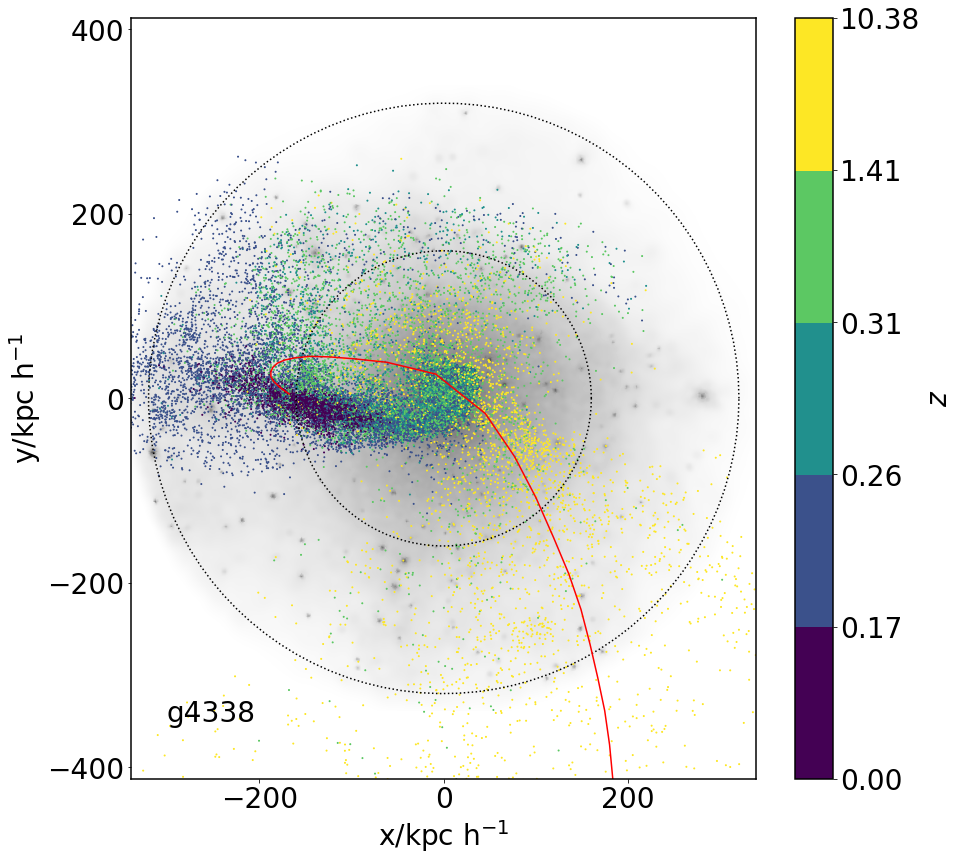

In [29]:
plotTheGal_cen(4338, 4337)

0.9999999999999999
0.9999999999999999
0.9885013870500643
0.9770844791104678
0.9657477271364222
0.9544895815144163
0.9433085022101076
0.9322029239204547
0.92117130426059
0.910212067552337
0.8993236455545738
0.8885044590798931
0.877752935938467
0.8670674727110801
0.8564464674992064
0.8458883035467388
0.8353913674569154
0.8249540073759147
0.8145745786449424
0.8042514289141498
0.7939828657390545
0.7837671892371252
0.7736027042569266
0.7634876592267225
0.7534203158154966
0.743398895625576
0.7334216014322112
0.7234866086200451
0.7135920749116283
0.7037361164408759
0.6939168360943404
0.6841322851243393
0.6743804984219314
0.6646594591725802
0.6549671195308365
0.6453013899266876
0.635660130510844
0.6260411596355442
0.616442238601731
0.6068610786989854
0.5972953209716013
0.5877425572256352


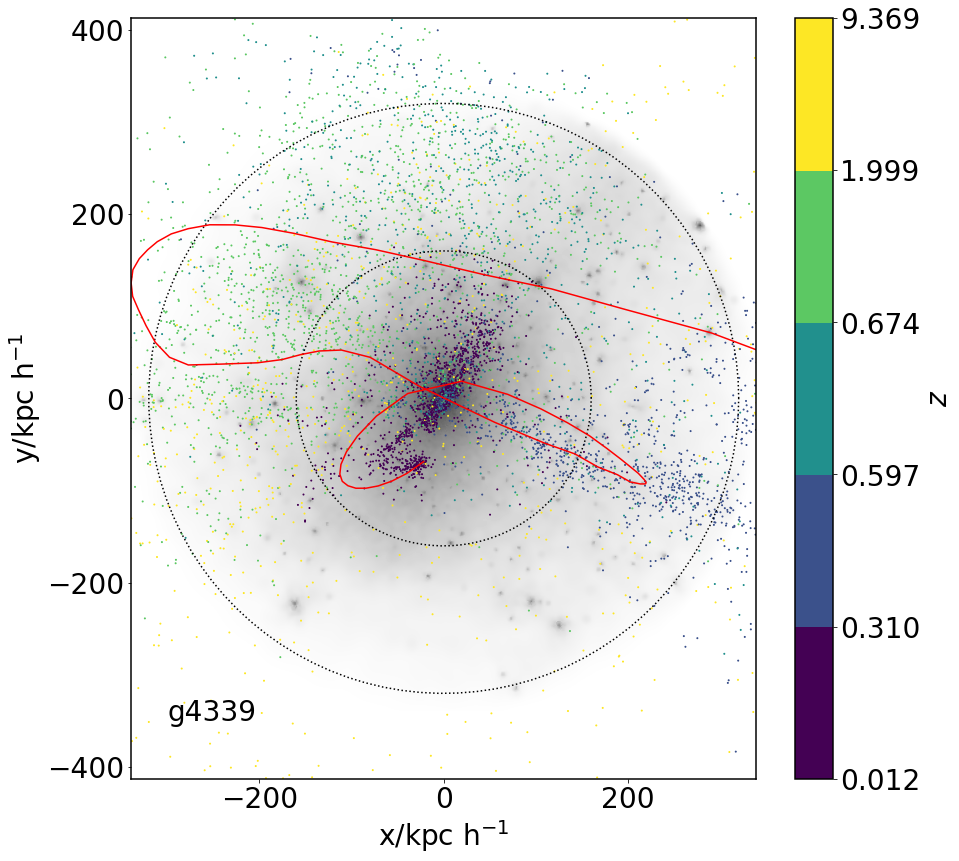

In [30]:
plotTheGal_cen(4339, 4337)

0.9999999999999999
0.9999999999999999
0.9885013870500643
0.9770844791104678
0.9657477271364222
0.9544895815144163
0.9433085022101076
0.9322029239204547
0.92117130426059
0.910212067552337
0.8993236455545738
0.8885044590798931
0.877752935938467
0.8670674727110801
0.8564464674992064
0.8458883035467388
0.8353913674569154
0.8249540073759147
0.8145745786449424
0.8042514289141498
0.7939828657390545
0.7837671892371252
0.7736027042569266
0.7634876592267225
0.7534203158154966
0.743398895625576


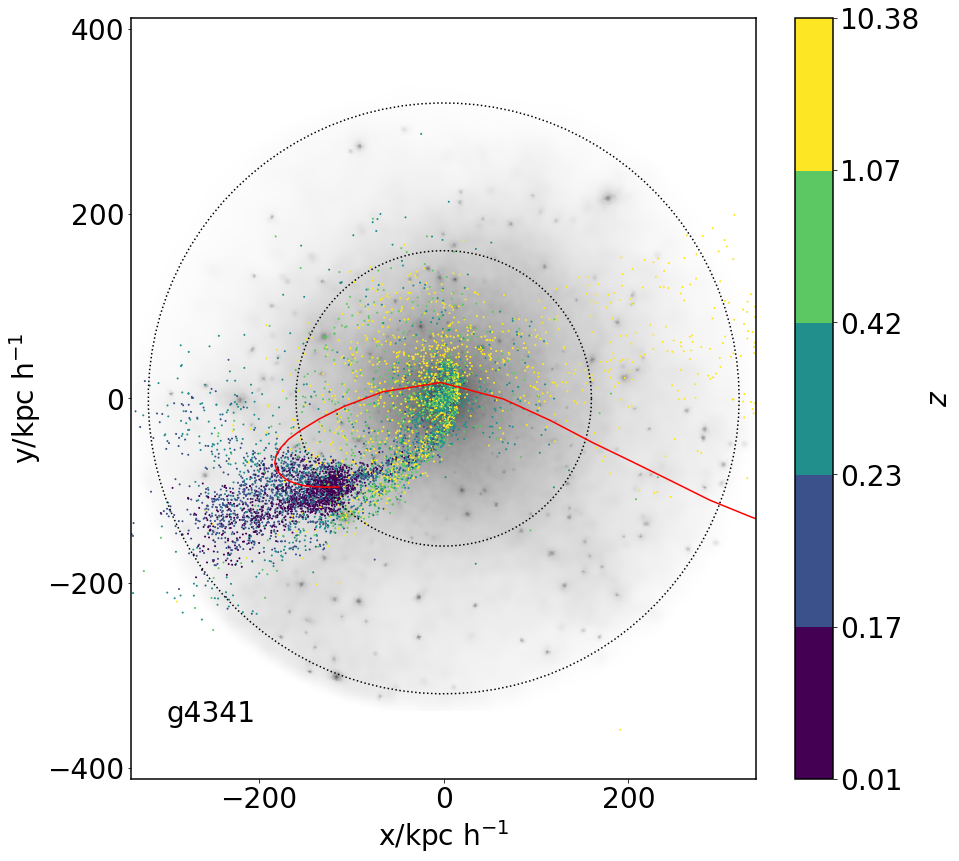

In [31]:
plotTheGal_cen(4341, 4337)

0.9999999999999999
0.9999999999999999
0.9885013870500643
0.9770844791104678
0.9657477271364222
0.9544895815144163
0.9433085022101076
0.9322029239204547
0.92117130426059
0.910212067552337
0.8993236455545738
0.8885044590798931
0.877752935938467
0.8670674727110801
0.8564464674992064
0.8458883035467388
0.8353913674569154
0.8249540073759147
0.8145745786449424
0.8042514289141498
0.7939828657390545
0.7837671892371252
0.7736027042569266
0.7634876592267225
0.7534203158154966
0.743398895625576
0.7334216014322112
0.7234866086200451
0.7135920749116283
0.7037361164408759
0.6939168360943404
0.6841322851243393
0.6743804984219314
0.6646594591725802
0.6549671195308365
0.6453013899266876
0.635660130510844
0.6260411596355442
0.616442238601731
0.6068610786989854
0.5972953209716013
0.5877425572256352
0.5782003007939306
0.5686659896467784
0.5591370009000125
0.5496106014742033


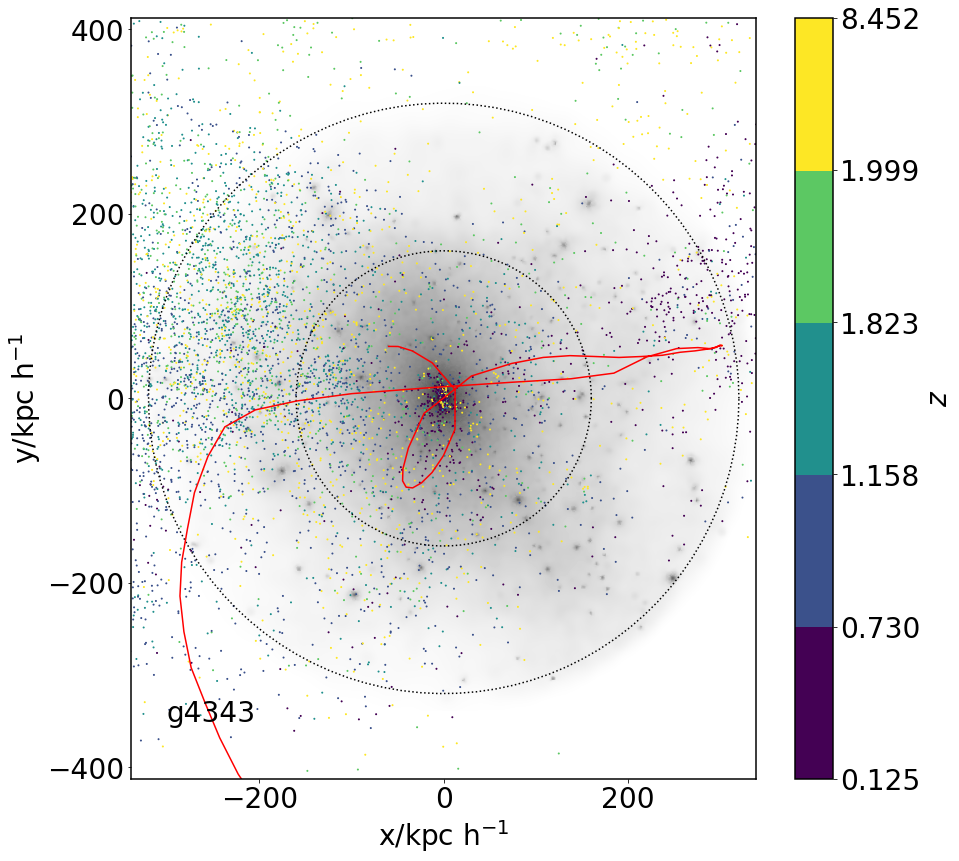

In [32]:
plotTheGal_cen(4343, 4337)

0.9999999999999999
0.9999999999999999
0.9885013870500643
0.9770844791104678
0.9657477271364222
0.9544895815144163
0.9433085022101076
0.9322029239204547
0.92117130426059
0.910212067552337
0.8993236455545738
0.8885044590798931
0.877752935938467
0.8670674727110801
0.8564464674992064
0.8458883035467388
0.8353913674569154
0.8249540073759147
0.8145745786449424
0.8042514289141498
0.7939828657390545
0.7837671892371252
0.7736027042569266
0.7634876592267225
0.7534203158154966
0.743398895625576
0.7334216014322112
0.7234866086200451
0.7135920749116283
0.7037361164408759
0.6939168360943404
0.6841322851243393
0.6743804984219314
0.6646594591725802
0.6549671195308365
0.6453013899266876
0.635660130510844


NameError: name 'mrot' is not defined

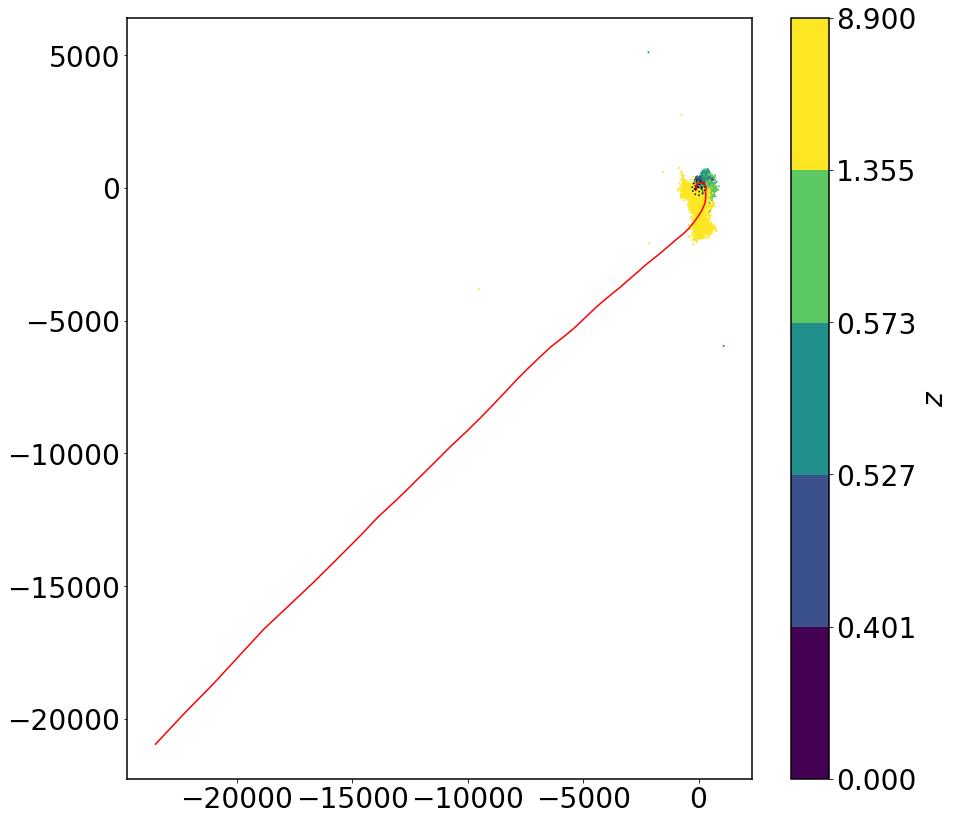

In [33]:
plotTheGal_cen(4470, 4469)

0.9999999999999999
0.9999999999999999
0.9885013870500643
0.9770844791104678
0.9657477271364222
0.9544895815144163
0.9433085022101076
0.9322029239204547
0.92117130426059
0.910212067552337
0.8993236455545738
0.8885044590798931
0.877752935938467
0.8670674727110801
0.8564464674992064
0.8458883035467388
0.8353913674569154
0.8249540073759147
0.8145745786449424
0.8042514289141498
0.7939828657390545
0.7837671892371252
0.7736027042569266
0.7634876592267225
0.7534203158154966
0.743398895625576
0.7334216014322112
0.7234866086200451
0.7135920749116283
0.7037361164408759
0.6939168360943404
0.6841322851243393
0.6743804984219314
0.6646594591725802
0.6549671195308365


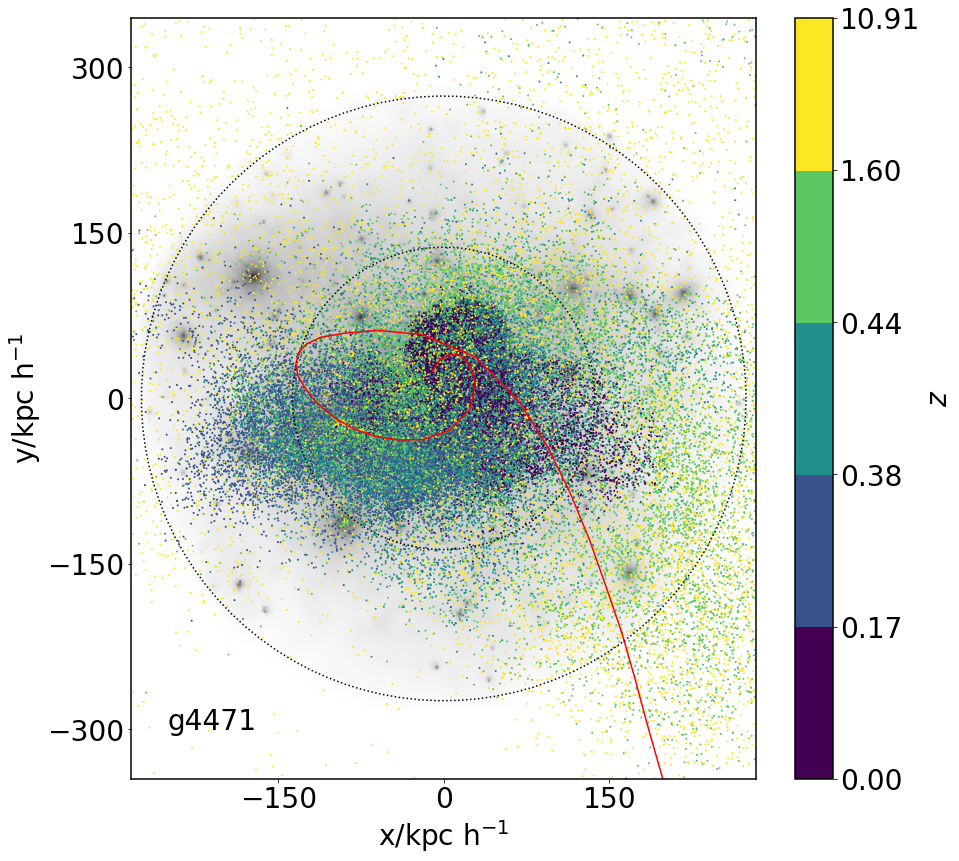

In [34]:
plotTheGal_cen(4471, 4469)

0.9999999999999999
0.9999999999999999
0.9885013870500643
0.9770844791104678
0.9657477271364222
0.9544895815144163
0.9433085022101076
0.9322029239204547
0.92117130426059
0.910212067552337
0.8993236455545738
0.8885044590798931
0.877752935938467
0.8670674727110801
0.8564464674992064
0.8458883035467388
0.8353913674569154
0.8249540073759147
0.8145745786449424
0.8042514289141498
0.7939828657390545
0.7837671892371252


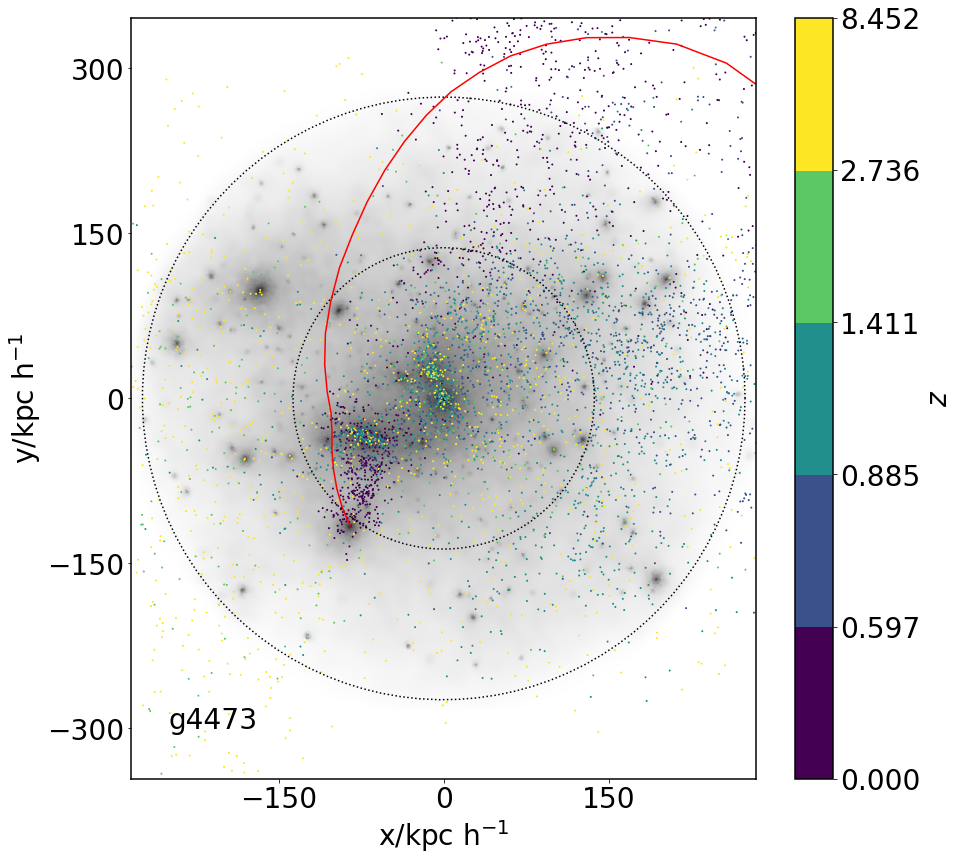

In [35]:
plotTheGal_cen(4473, 4469)

0.9999999999999999
0.9999999999999999
0.9885013870500643
0.9770844791104678
0.9657477271364222
0.9544895815144163
0.9433085022101076
0.9322029239204547
0.92117130426059
0.910212067552337
0.8993236455545738
0.8885044590798931
0.877752935938467
0.8670674727110801
0.8564464674992064
0.8458883035467388
0.8353913674569154
0.8249540073759147
0.8145745786449424
0.8042514289141498
0.7939828657390545
0.7837671892371252
0.7736027042569266
0.7634876592267225
0.7534203158154966
0.743398895625576
0.7334216014322112
0.7234866086200451
0.7135920749116283
0.7037361164408759
0.6939168360943404
0.6841322851243393
0.6743804984219314


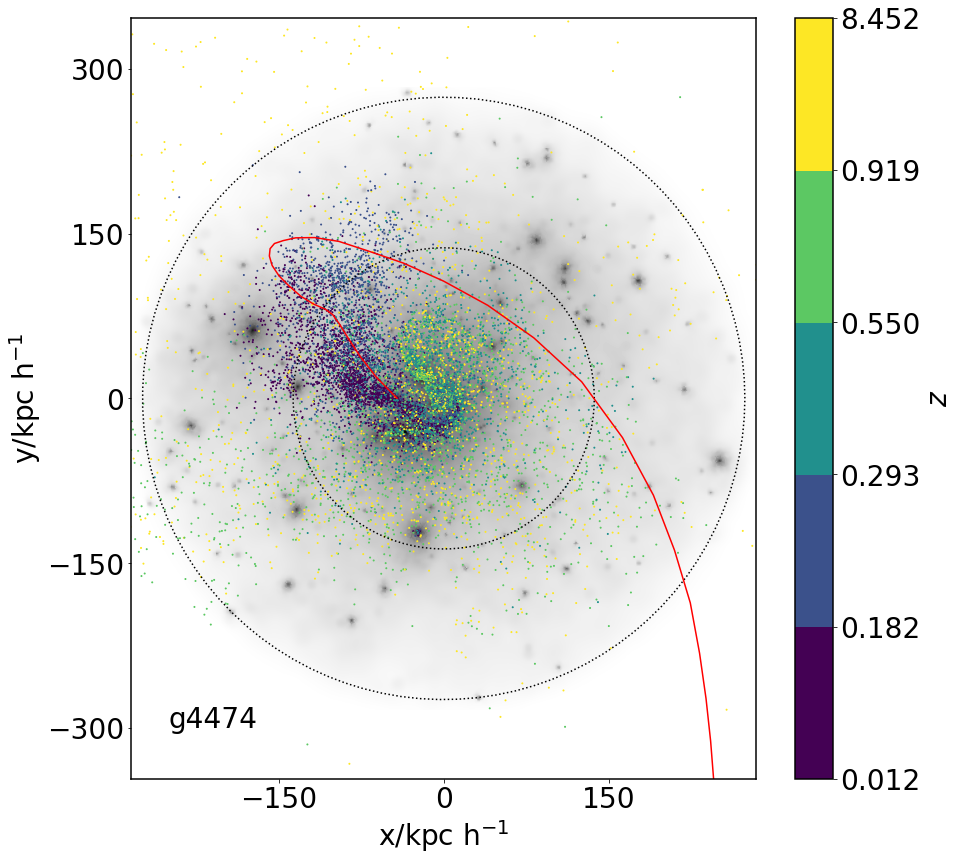

In [36]:
plotTheGal_cen(4474, 4469)

In [ ]:
# and now do some time travel, i don't know if stars only or what, i think or what
def getAllLastP_IDs(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, zlist = [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            # now we keep only theones between r_optical
            
            #rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
            
            #posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
            #posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            
            #xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
            #rr = np.sqrt(xx**2+yy**2+zz**2)
            
            #ik = np.where(rr<rop)[0]
            
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            #tempIds = tempIds[ik]
            
            Idlist.extend(list(tempIds))
            zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            zlist.extend([zs]*tempIds.size)
            

    Idlist = np.array(Idlist)
    zlist = np.array(zlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    zlist = zlist[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
    posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
    rr = np.sqrt(xx**2+yy**2+zz**2)
            
    ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    zorder = np.zeros(IndexT_.size)
    zorder[is1] = zlist_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0]
#     IndexT_near_ = IndexT_near[icut2]
        
#     zorder_ = zorder[icut2]

    IndexT_near_ = IndexT_near
        
    zorder_ = zorder
#     NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near_]
    IDs = sim['SnapNumber_128/PartType0/ParticleIDs'][IndexT_near_]

    return IDs, zorder_

def getAllLastPStars_IDs(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at the maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            
            rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
            
            posPart = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
            posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            
            xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
            rr = np.sqrt(xx**2+yy**2+zz**2)
            
            ik = np.where(rr<rop)[0]
            
            tempIds = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            tempIds = tempIds[ik]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalStars, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
            
    posPart = sim['SnapNumber_128/PartType4/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
            
    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
    rr = np.sqrt(xx**2+yy**2+zz**2)
            
    ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType4/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    TdayIDs = TdayIDs[ik]
    
    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalStars, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType4/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0]
#     IndexT_near_ = IndexT_near[icut2]

    IndexT_near_ = IndexT_near
        
    #NearCoord = sim['SnapNumber_128/PartType4/Coordinates'][IndexT_near_]
    IDs = sim['SnapNumber_128/PartType4/ParticleIDs'][IndexT_near_]
    # WARNING, dangerous replacement
#     temporder_near = sim['SnapNumber_128/PartType0/StarFormationRate'][IndexT_near]
    #END WARNING
    
#     IE0 = sim['SnapNumber_128/PartType0/InternalEnergy'][IndexT_near]
#     ne10 = sim['SnapNumber_128/PartType0/ElectronAbundance'][IndexT_near]
#     t0 = tempFromMass(GasMasses, GassAbundances, IE0, ne10)
    
#     temporder_near = temporder_near - t0
#     temporder_near = t0 # not so subtle replacement
    # first lets re-define coordinates in a galactocentric scheme.
#     X, Y, Z = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]
    
    return IDs

In [ ]:
gal, cen = 4339, 4337 

IDsGal, zorder = getAllLastP_IDs(gal, cen)
IDsStar = getAllLastPStars_IDs(gal, cen)

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
offDMgro = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

notIDs = np.isin(TdayTotalIDs, IDsGal)
notIDs_ = np.where(notIDs)[0]
NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][notIDs_]
X, Y, Z = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

notIDs_S = np.isin(TdayTotalStars, IDsStar)
notIDs_S_ = np.where(notIDs_S)[0]
NearCoord_S = sim['SnapNumber_128/PartType4/Coordinates'][notIDs_S_]
Xsl, Ysl, Zsl = NearCoord_S[:,0] - posCen[0], NearCoord_S[:,1] - posCen[1], NearCoord_S[:,2] - posCen[2]

r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

pos = posGal -posCen

posDM = sim['SnapNumber_128/PartType1/Coordinates'][offDMgro[0]:offDMgro[1]]
Xg, Yg, Zg = posDM[:,0] - posCen[0], posDM[:,1] - posCen[1], posDM[:,2] - posCen[2]
r = np.sqrt(Xg**2+Yg**2.+Zg**2.)
rmax = r.max()

posDMtot = sim['SnapNumber_128/PartType1/Coordinates'][()]
Xgg, Ygg, Zgg = posDMtot[:,0] - posCen[0], posDMtot[:,1] - posCen[1], posDMtot[:,2] - posCen[2]
rr = np.sqrt(Xgg**2+Ygg**2.+Zgg**2.)
i = np.where(rr<rmax)

Xg, Yg, Zg = Xgg[i], Ygg[i], Zgg[i]

offstar = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
PoStar = sim['SnapNumber_128/PartType4/Coordinates'][offstar[0]:offstar[1]]
xS, yS, zS = PoStar[:,0] - posCen[0], PoStar[:,1] - posCen[1], PoStar[:,2] - posCen[2]


velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

vel = velGal- velCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

newP = np.array([Xg, Yg, Zg]).T

XR, YR, ZR = [], [], []

for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
    XR.append(dV[0])
    YR.append(dV[1])
    ZR.append(dV[2])
    
XR, YR, ZR = np.array(XR), np.array(YR), np.array(ZR)

XRS, YRS, ZRS = [], [], []
for x, y, z in zip(xS, yS, zS):
    dV = np.matmul(RM, np.array([x, y, z]))
    XRS.append(dV[0])
    YRS.append(dV[1])
    ZRS.append(dV[2])
    
XRS, YRS, ZRS = np.array(XRS), np.array(YRS), np.array(ZRS)


XRL, YRL, ZRL = [], [], []
for x, y, z in zip(Xsl, Ysl, Zsl):
    dV = np.matmul(RM, np.array([x, y, z]))
    XRL.append(dV[0])
    YRL.append(dV[1])
    ZRL.append(dV[2])
    
XRL, YRL, ZRL = np.array(XRL), np.array(YRL), np.array(ZRL)

newPR = []
for v in newP:
    dV = np.matmul(RM, v)
       
    newPR.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x
    
newPR = np.array(newPR)

# and the orbit

xo, yo, zo = [], [], []

uniqueID = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+cen)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
   
xM, yM, zM = 0, 0, 0  
for mm, mmC in zip(mtree, mtreeC): # ignore the first one
    snap, idd = split_unique_id(int(mm))
    snapC, iddC = split_unique_id(int(mmC))
    
    pg = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    pc = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    
    ps = pg - pc
    xo.append(ps[0])
    yo.append(ps[1])
    zo.append(ps[2])
    
    if snap==101:
        xM, yM, zM = ps[0], ps[1], ps[2]
    
xo, yo, zo = np.array(xo), np.array(yo), np.array(zo)


xor, yor, zor = [], [], []
for x, y, z in zip(xo, yo, zo):
    dV = np.matmul(RM, np.array([x, y, z]))
    xor.append(dV[0])
    yor.append(dV[1])
    zor.append(dV[2])
    
xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)

mrot = np.matmul(RM, np.array([xM, yM, zM]))

In [ ]:
fig, ax = pl.subplots(figsize=(14,14))

pp = np.linspace(0, 100, 11)
vv = np.percentile(zorder, pp)
norm = mpc.BoundaryNorm(boundaries=vv, ncolors=256)

pl.scatter(YR, ZR, s=1, label='Stripped Gas', c=zorder, norm=norm)
# pl.scatter(YRS, ZRS, s=1, label='Stars')
# pl.scatter(YRL, ZRL, s=30, label='Stripped Stars')
pl.plot(YRS, ZRS, marker='o', label='Stars', ls=' ', markersize=0.5)
pl.plot(YRL, ZRL, label='Stripped Stars',marker='o', ls=' ', markersize=5)

#pl.scatter(0., 0., color='black')

bar = pl.colorbar(label='$z$')
bar.set_ticks(vv)

pl.legend(loc='best')

pl.plot(yor, zor, ls='-', color='red')

t = np.linspace(0., 2.*np.pi, 100)
x0, y0 = r200*np.cos(t), r200*np.sin(t)
    
pl.plot(x0, y0, ls=':', color='black')
pl.plot(2*x0, 2*y0, ls=':', color='black')
# pl.scatter(mrot[1], mrot[2], marker='o', color='red', s=500)
# pl.plot(mrot[1], mrot[2], marker='o', color='red', ls=' ', markersize=25)

pl.xlabel('x/kpc h⁻¹')
pl.ylabel('y/kpc h⁻¹')

pl.axis('equal')
qv = QuickView(newPR, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r')

In [ ]:
# now for any snapshot

gal, cen = 4339, 4337 

IDsGal, zorder = getAllLastP_IDs(gal, cen)
#IDsStar = getAllLastPStars_IDs(gal, cen)

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
offDMgro = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

posDM = sim['SnapNumber_128/PartType1/Coordinates'][offDMgro[0]:offDMgro[1]]
Xg, Yg, Zg = posDM[:,0] - posCen[0], posDM[:,1] - posCen[1], posDM[:,2] - posCen[2]
r = np.sqrt(Xg**2+Yg**2.+Zg**2.)
rmax = r.max()

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

pos = posGal - posCen
vel = velGal- velCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

xo, yo, zo = [], [], []

uniqueID = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+cen)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
   
xM, yM, zM = 0, 0, 0  
for mm, mmC in zip(mtree, mtreeC): # ignore the first one
    snap, idd = split_unique_id(int(mm))
    snapC, iddC = split_unique_id(int(mmC))
    
    pg = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    pc = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    
    ps = pg - pc
    xo.append(ps[0])
    yo.append(ps[1])
    zo.append(ps[2])
    
    if snap==101:
        xM, yM, zM = ps[0], ps[1], ps[2]
    
xo, yo, zo = np.array(xo), np.array(yo), np.array(zo)


xor, yor, zor = [], [], []
for x, y, z in zip(xo, yo, zo):
    dV = np.matmul(RM, np.array([x, y, z]))
    xor.append(dV[0])
    yor.append(dV[1])
    zor.append(dV[2])
    
xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)


# i think this part is fixed, the following are not

thesnap = 128

SnapGasIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(thesnap)][()]
#SnapStarIDs = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(thesnap)][()]

posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(thesnap)][cen]
posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(thesnap)][gal]

notIDs = np.isin(SnapGasIDs, IDsGal)
notIDs_ = np.where(notIDs)[0]
NearCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(thesnap)][notIDs_]

X, Y, Z = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

print(X.shape, Y.shape, Z.shape)

#notIDs_S = np.isin(SnapStarIDs, IDsStar)
#notIDs_S_ = np.where(notIDs_S)[0]
#NearCoord_S = sim['SnapNumber_{}/PartType4/Coordinates'.format(thesnap)][notIDs_S_]
#Xsl, Ysl, Zsl = NearCoord_S[:,0] - posCen[0], NearCoord_S[:,1] - posCen[1], NearCoord_S[:,2] - posCen[2]

posDMtot = sim['SnapNumber_{}/PartType1/Coordinates'.format(thesnap)][()]
Xgg, Ygg, Zgg = posDMtot[:,0] - posCen[0], posDMtot[:,1] - posCen[1], posDMtot[:,2] - posCen[2]
rr = np.sqrt(Xgg**2+Ygg**2.+Zgg**2.)
i = np.where(rr<rmax)

Xg, Yg, Zg = Xgg[i], Ygg[i], Zgg[i]

#offstar = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(thesnap)][gal].astype('int')
#PoStar = sim['SnapNumber_{}/PartType4/Coordinates'.format(thesnap)][offstar[0]:offstar[1]]
#xS, yS, zS = PoStar[:,0] - posCen[0], PoStar[:,1] - posCen[1], PoStar[:,2] - posCen[2]

newP = np.array([Xg, Yg, Zg]).T

XR, YR, ZR = [], [], []

for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RM, np.array([x, y, z]))
    XR.append(dV[0])
    YR.append(dV[1])
    ZR.append(dV[2])
    
XR, YR, ZR = np.array(XR), np.array(YR), np.array(ZR)

# XRS, YRS, ZRS = [], [], []
# for x, y, z in zip(xS, yS, zS):
#     dV = np.matmul(RM, np.array([x, y, z]))
#     XRS.append(dV[0])
#     YRS.append(dV[1])
#     ZRS.append(dV[2])
    
# XRS, YRS, ZRS = np.array(XRS), np.array(YRS), np.array(ZRS)

XRL, YRL, ZRL = [], [], []
for x, y, z in zip(Xsl, Ysl, Zsl):
    dV = np.matmul(RM, np.array([x, y, z]))
    XRL.append(dV[0])
    YRL.append(dV[1])
    ZRL.append(dV[2])
    
XRL, YRL, ZRL = np.array(XRL), np.array(YRL), np.array(ZRL)

newPR = []
for v in newP:
    dV = np.matmul(RM, v)
       
    newPR.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x
    
newPR = np.array(newPR)

# and the orbit, done

xor, yor, zor = [], [], []
for x, y, z in zip(xo, yo, zo):
    dV = np.matmul(RM, np.array([x, y, z]))
    xor.append(dV[0])
    yor.append(dV[1])
    zor.append(dV[2])
    
xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)

mrot = np.matmul(RM, np.array([xM, yM, zM]))

fig, ax = pl.subplots(figsize=(14,14))

pp = np.linspace(0, 100, 11)
vv = np.percentile(zorder, pp)
norm = mpc.BoundaryNorm(boundaries=vv, ncolors=256)

pl.scatter(YR, ZR, s=1, label='Stripped Gas', c=zorder, norm=norm)
# pl.scatter(YRS, ZRS, s=1, label='Stars')
# pl.scatter(YRL, ZRL, s=30, label='Stripped Stars')
pl.plot(YRS, ZRS, marker='o', label='Stars', ls=' ', markersize=0.5)
pl.plot(YRL, ZRL, label='Stripped Stars',marker='o', ls=' ', markersize=5)

#pl.scatter(0., 0., color='black')

bar = pl.colorbar(label='$z$')
bar.set_ticks(vv)

pl.legend(loc='best')

pl.plot(yor, zor, ls='-', color='red')

t = np.linspace(0., 2.*np.pi, 100)
x0, y0 = r200*np.cos(t), r200*np.sin(t)
    
pl.plot(x0, y0, ls=':', color='black')
pl.plot(2*x0, 2*y0, ls=':', color='black')
# pl.scatter(mrot[1], mrot[2], marker='o', color='red', s=500)
# pl.plot(mrot[1], mrot[2], marker='o', color='red', ls=' ', markersize=25)

pl.xlabel('x/kpc h⁻¹')
pl.ylabel('y/kpc h⁻¹')

pl.axis('equal')
qv = QuickView(newPR, r='infinity', plot=False)
qv.imshow(cmap='gist_gray_r')

In [ ]:
# and now sequential
# now for any snapshot

gal, cen = 4343, 4337

otherGals = [4338, 4339, 4341]

IDsGal, zorder = getAllLastP_IDs(gal, cen)
# IDsStar = getAllLastPStars_IDs(gal, cen)

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
offDMgro = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

posDM = sim['SnapNumber_128/PartType1/Coordinates'][offDMgro[0]:offDMgro[1]]
Xg, Yg, Zg = posDM[:,0] - posCen[0], posDM[:,1] - posCen[1], posDM[:,2] - posCen[2]
r = np.sqrt(Xg**2+Yg**2.+Zg**2.)
rmax = r.max()

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

pos = posGal - posCen
vel = velGal- velCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

xo, yo, zo = [], [], []

uniqueID = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+cen)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
   
xM, yM, zM = 0, 0, 0  
for mm, mmC in zip(mtree, mtreeC): # ignore the first one
    snap, idd = split_unique_id(int(mm))
    snapC, iddC = split_unique_id(int(mmC))
    
    pg = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    pc = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    
    ps = pg - pc
    xo.append(ps[0])
    yo.append(ps[1])
    zo.append(ps[2])
    
    if snap==101:
        xM, yM, zM = ps[0], ps[1], ps[2]
    
xo, yo, zo = np.array(xo), np.array(yo), np.array(zo)


xor, yor, zor = [], [], []
for x, y, z in zip(xo, yo, zo):
    dV = np.matmul(RM, np.array([x, y, z]))
    xor.append(dV[0])
    yor.append(dV[1])
    zor.append(dV[2])
    
xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)


# and the orbit of teh rest of the galaxies

otheX, otheY, otheZ = [], [], []
for go in otherGals:
    xoO, yoO, zoO = [], [], []

    uniqueIDO = int(128*1e6+go)
    streeO = networkx.dfs_tree(trees, str(uniqueIDO))
    mtreeO = get_main_branch_unique_ids(streeO, str(uniqueIDO))

    xMO, yMO, zMO = 0, 0, 0  
    for mm, mmC in zip(mtreeO, mtreeC): # ignore the first one
        snapO, iddO = split_unique_id(int(mm))
        snapCO, iddCO = split_unique_id(int(mmC))

        pgO = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapO)][iddO]
        pcO = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapO)][iddCO]

        psO = pgO - pcO
        xoO.append(psO[0])
        yoO.append(psO[1])
        zoO.append(psO[2])

        if snapO ==101:
            xMO, yMO, zMO = psO[0], psO[1], psO[2]

    xoO, yoO, zoO = np.array(xoO), np.array(yoO), np.array(zoO)

    xorO, yorO, zorO = [], [], []
    for x, y, z in zip(xoO, yoO, zoO):
        dV = np.matmul(RM, np.array([x, y, z]))
        xorO.append(dV[0])
        yorO.append(dV[1])
        zorO.append(dV[2])

    xorO, yorO, zorO = np.array(xorO), np.array(yorO), np.array(zorO)
    
    otheX.append(xorO)
    otheY.append(yorO)
    otheZ.append(zorO) 

ror = np.sqrt(xor**2+yor**2+zor**2)
thisfar = np.where(ror<=rmax)

# i think this part is fixed, the following are not

mtree, mtreeC = np.array(mtree), np.array(mtreeC)

I = len(mtree[thisfar])

print(I, rmax, r200)

c = 0
for mm, mmC in zip(mtree[thisfar], mtreeC[thisfar]):
    thesnap, idd = split_unique_id(int(mm))
    thesnapC, iddC = split_unique_id(int(mmC))

    SnapGasIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(thesnap)][()]
#     SnapStarIDs = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(thesnap)][()]

    posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(thesnap)][iddC]
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(thesnap)][idd]

    notIDs = np.isin(SnapGasIDs, IDsGal)
    notIDs_ = np.where(notIDs)[0]
    NearCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(thesnap)][notIDs_]

    X, Y, Z = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

    survIds = np.isin(IDsGal, SnapGasIDs[notIDs_])
    survIds_ = np.where(survIds)
    zorder_ = zorder[survIds]
    
#     notIDs_S = np.isin(SnapStarIDs, IDsStar)
#     notIDs_S_ = np.where(notIDs_S)[0]
#     NearCoord_S = sim['SnapNumber_{}/PartType4/Coordinates'.format(thesnap)][notIDs_S_]
#     Xsl, Ysl, Zsl = NearCoord_S[:,0] - posCen[0], NearCoord_S[:,1] - posCen[1], NearCoord_S[:,2] - posCen[2]

    posDMtot = sim['SnapNumber_{}/PartType1/Coordinates'.format(thesnap)][()]
    Xgg, Ygg, Zgg = posDMtot[:,0] - posCen[0], posDMtot[:,1] - posCen[1], posDMtot[:,2] - posCen[2]
    rr = np.sqrt(Xgg**2+Ygg**2.+Zgg**2.)
    i = np.where(rr<rmax)

    Xg, Yg, Zg = Xgg[i], Ygg[i], Zgg[i]

#     offstar = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(thesnap)][idd].astype('int')
#     PoStar = sim['SnapNumber_{}/PartType4/Coordinates'.format(thesnap)][offstar[0]:offstar[1]]
#     xS, yS, zS = PoStar[:,0] - posCen[0], PoStar[:,1] - posCen[1], PoStar[:,2] - posCen[2]

    newP = np.array([Xg, Yg, Zg]).T

    XR, YR, ZR = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RM, np.array([x, y, z]))
        XR.append(dV[0])
        YR.append(dV[1])
        ZR.append(dV[2])

    XR, YR, ZR = np.array(XR), np.array(YR), np.array(ZR)

#     XRS, YRS, ZRS = [], [], []
#     for x, y, z in zip(xS, yS, zS):
#         dV = np.matmul(RM, np.array([x, y, z]))
#         XRS.append(dV[0])
#         YRS.append(dV[1])
#         ZRS.append(dV[2])

#     XRS, YRS, ZRS = np.array(XRS), np.array(YRS), np.array(ZRS)

#     XRL, YRL, ZRL = [], [], []
#     for x, y, z in zip(Xsl, Ysl, Zsl):
#         dV = np.matmul(RM, np.array([x, y, z]))
#         XRL.append(dV[0])
#         YRL.append(dV[1])
#         ZRL.append(dV[2])

#    XRL, YRL, ZRL = np.array(XRL), np.array(YRL), np.array(ZRL)

    newPR = []
    for v in newP:
        dV = np.matmul(RM, v)

        newPR.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x

    newPR = np.array(newPR)

    # and the orbit, done

    xor, yor, zor = [], [], []
    for x, y, z in zip(xo, yo, zo):
        dV = np.matmul(RM, np.array([x, y, z]))
        xor.append(dV[0])
        yor.append(dV[1])
        zor.append(dV[2])

    xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)

    mrot = np.matmul(RM, np.array([xM, yM, zM]))

    fig, ax = pl.subplots(figsize=(14,14))

    pp = np.linspace(0, 100, 6) 
    vv = np.percentile(zorder, pp)
    if gal==4470:
        vv = np.array([0.012, 0.401, 0.527, 0.573, 1.355, 8.9])
    norm = mpc.BoundaryNorm(boundaries=vv, ncolors=256)

    pl.scatter(YR, XR, s=1, label='Stripped Gas', c=zorder_, norm=norm)
    # pl.scatter(YRS, ZRS, s=1, label='Stars')
    # pl.scatter(YRL, ZRL, s=30, label='Stripped Stars')
#     pl.plot(YRS, ZRS, marker='o', label='Stars', ls=' ', markersize=0.5)
#     pl.plot(YRL, ZRL, label='Stripped Stars',marker='o', ls=' ', markersize=5)

    pl.plot(yor[c], xor[c], marker='o', color='red', markersize=10)
    #pl.scatter(0., 0., color='black')

    bar = pl.colorbar(label='$z$')
    bar.set_ticks(vv)

#     pl.legend(loc='best')

    pl.plot(yor, xor, ls='-', color='red')

    for yorO, zorO in zip(otheY, otheX):
        pl.plot(yorO, zorO, ls='-.', color='blue')
    
    t = np.linspace(0., 2.*np.pi, 100)
    x0, y0 = r200*np.cos(t), r200*np.sin(t)

    pl.plot(x0, y0, ls=':', color='black')
    pl.plot(2*x0, 2*y0, ls=':', color='black')
    # pl.scatter(mrot[1], mrot[2], marker='o', color='red', s=500)
#     pl.plot(mrot[1], mrot[2], marker='o', color='red', ls=' ', markersize=25)

    
    if cen==4337:
        pl.xticks((-400,-200,0,200,400))
        pl.yticks((-400,-200,0,200,400))
        pl.text(-300, -350, 'g{}'.format(gal))
        
    else:
        pl.xticks((-300,-150,0,150,300))
        pl.yticks((-300,-150,0,150,300))
        pl.text(-250, -300, 'g{}'.format(gal))
        
    pl.xlabel('x/kpc h$^{-1}$')
    pl.ylabel('z/kpc h$^{-1}$')
    
    pl.axis('equal')
    qv = QuickView(newPR, r='infinity', plot=False)
    qv.imshow(cmap='gist_gray_r')
    

    
    nuu = str(I-c).zfill(3)
    fig.savefig('OFe_test/OrbitStream_OtherGal_XZ_{}_{}.png'.format(gal, nuu))
    
    c += 1
    pl.close()

In [ ]:
# and now sequential
# now for any snapshot

gal, cen = 4338, 4337 

IDsGal, zorder = getAllLastP_IDs(gal, cen)
IDsStar = getAllLastPStars_IDs(gal, cen)

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
offDMgro = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

posDM = sim['SnapNumber_128/PartType1/Coordinates'][offDMgro[0]:offDMgro[1]]
Xg, Yg, Zg = posDM[:,0] - posCen[0], posDM[:,1] - posCen[1], posDM[:,2] - posCen[2]
r = np.sqrt(Xg**2+Yg**2.+Zg**2.)
rmax = r.max()

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

pos = posGal - posCen
vel = velGal- velCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

xo, yo, zo = [], [], []

uniqueID = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+cen)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
   
xM, yM, zM = 0, 0, 0  
for mm, mmC in zip(mtree, mtreeC): # ignore the first one
    snap, idd = split_unique_id(int(mm))
    snapC, iddC = split_unique_id(int(mmC))
    
    pg = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    pc = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    
    ps = pg - pc
    xo.append(ps[0])
    yo.append(ps[1])
    zo.append(ps[2])
    
    if snap==101:
        xM, yM, zM = ps[0], ps[1], ps[2]
    
xo, yo, zo = np.array(xo), np.array(yo), np.array(zo)


xor, yor, zor = [], [], []
for x, y, z in zip(xo, yo, zo):
    dV = np.matmul(RM, np.array([x, y, z]))
    xor.append(dV[0])
    yor.append(dV[1])
    zor.append(dV[2])
    
xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)

ror = np.sqrt(xor**2+yor**2+zor**2)
thisfar = np.where(ror<=rmax)

# i think this part is fixed, the following are not

mtree, mtreeC = np.array(mtree), np.array(mtreeC)

I = len(mtree[thisfar])

print(I, rmax, r200)

c = 0
for mm, mmC in zip(mtree[thisfar], mtreeC[thisfar]):
    thesnap, idd = split_unique_id(int(mm))
    thesnapC, iddC = split_unique_id(int(mmC))

    SnapGasIDs = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(thesnap)][()]
    SnapStarIDs = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(thesnap)][()]

    posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(thesnap)][iddC]
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(thesnap)][idd]

    notIDs = np.isin(SnapGasIDs, IDsGal)
    notIDs_ = np.where(notIDs)[0]
    NearCoord = sim['SnapNumber_{}/PartType0/Coordinates'.format(thesnap)][notIDs_]

    X, Y, Z = NearCoord[:,0] - posCen[0], NearCoord[:,1] - posCen[1], NearCoord[:,2] - posCen[2]

    survIds = np.isin(IDsGal, SnapGasIDs[notIDs_])
    survIds_ = np.where(survIds)
    zorder_ = zorder[survIds]
    
    notIDs_S = np.isin(SnapStarIDs, IDsStar)
    notIDs_S_ = np.where(notIDs_S)[0]
    NearCoord_S = sim['SnapNumber_{}/PartType4/Coordinates'.format(thesnap)][notIDs_S_]
    Xsl, Ysl, Zsl = NearCoord_S[:,0] - posCen[0], NearCoord_S[:,1] - posCen[1], NearCoord_S[:,2] - posCen[2]

    posDMtot = sim['SnapNumber_{}/PartType1/Coordinates'.format(thesnap)][()]
    Xgg, Ygg, Zgg = posDMtot[:,0] - posCen[0], posDMtot[:,1] - posCen[1], posDMtot[:,2] - posCen[2]
    rr = np.sqrt(Xgg**2+Ygg**2.+Zgg**2.)
    i = np.where(rr<rmax)

    Xg, Yg, Zg = Xgg[i], Ygg[i], Zgg[i]

    offstar = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(thesnap)][idd].astype('int')
    PoStar = sim['SnapNumber_{}/PartType4/Coordinates'.format(thesnap)][offstar[0]:offstar[1]]
    xS, yS, zS = PoStar[:,0] - posCen[0], PoStar[:,1] - posCen[1], PoStar[:,2] - posCen[2]

    newP = np.array([Xg, Yg, Zg]).T

    XR, YR, ZR = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RM, np.array([x, y, z]))
        XR.append(dV[0])
        YR.append(dV[1])
        ZR.append(dV[2])

    XR, YR, ZR = np.array(XR), np.array(YR), np.array(ZR)

    XRS, YRS, ZRS = [], [], []
    for x, y, z in zip(xS, yS, zS):
        dV = np.matmul(RM, np.array([x, y, z]))
        XRS.append(dV[0])
        YRS.append(dV[1])
        ZRS.append(dV[2])

    XRS, YRS, ZRS = np.array(XRS), np.array(YRS), np.array(ZRS)

    XRL, YRL, ZRL = [], [], []
    for x, y, z in zip(Xsl, Ysl, Zsl):
        dV = np.matmul(RM, np.array([x, y, z]))
        XRL.append(dV[0])
        YRL.append(dV[1])
        ZRL.append(dV[2])

    XRL, YRL, ZRL = np.array(XRL), np.array(YRL), np.array(ZRL)

    newPR = []
    for v in newP:
        dV = np.matmul(RM, v)

        newPR.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x

    newPR = np.array(newPR)

    # and the orbit, done

    xor, yor, zor = [], [], []
    for x, y, z in zip(xo, yo, zo):
        dV = np.matmul(RM, np.array([x, y, z]))
        xor.append(dV[0])
        yor.append(dV[1])
        zor.append(dV[2])

    xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)

    mrot = np.matmul(RM, np.array([xM, yM, zM]))

    fig, ax = pl.subplots(figsize=(14,14))

    pp = np.linspace(0, 100, 11)
    vv = np.percentile(zorder, pp)
    norm = mpc.BoundaryNorm(boundaries=vv, ncolors=256)

#     pl.scatter(YR, ZR, s=1, label='Stripped Gas', c=zorder_, norm=norm)
    # pl.scatter(YRS, ZRS, s=1, label='Stars')
    # pl.scatter(YRL, ZRL, s=30, label='Stripped Stars')
    pl.plot(np.median(YRS), np.median(ZRS), marker='o', label='Stars', ls=' ', markersize=5)
#     pl.plot(YRL, ZRL, label='Stripped Stars',marker='o', ls=' ', markersize=5)

    #pl.scatter(0., 0., color='black')

#     bar = pl.colorbar(label='$z$')
#     bar.set_ticks(vv)

    pl.legend(loc='best')

    pl.plot(yor, zor, ls='-', color='red')

    t = np.linspace(0., 2.*np.pi, 100)
    x0, y0 = r200*np.cos(t), r200*np.sin(t)

    pl.plot(x0, y0, ls=':', color='black')
    pl.plot(2*x0, 2*y0, ls=':', color='black')
    # pl.scatter(mrot[1], mrot[2], marker='o', color='red', s=500)
    # pl.plot(mrot[1], mrot[2], marker='o', color='red', ls=' ', markersize=25)

    pl.xlabel('x/kpc h⁻¹')
    pl.ylabel('y/kpc h⁻¹')

    pl.axis('equal')
    qv = QuickView(newPR, r='infinity', plot=False)
    qv.imshow(cmap='gist_gray_r')
    
    nuu = str(I-c).zfill(3)
    fig.savefig('OFe_test/OrbitStream_test_{}_{}.png'.format(gal, nuu))
    
    c += 1
    pl.close()

In [ ]:
def plotTheGal_trans(gal, cen):

    X, Y, Z, zorder = getAllLastP(gal, cen)
    Xsl, Ysl, Zsl = getAllLastPStars(gal, cen)

    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
    offDMgro = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

    
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    pos = posGal -posCen

    posDM = sim['SnapNumber_128/PartType1/Coordinates'][offDMgro[0]:offDMgro[1]]
    Xg, Yg, Zg = posDM[:,0] - posCen[0], posDM[:,1] - posCen[1], posDM[:,2] - posCen[2]
    r = np.sqrt(Xg**2+Yg**2.+Zg**2.)
    rmax = r.max()

    posDMtot = sim['SnapNumber_128/PartType1/Coordinates'][()]
    Xgg, Ygg, Zgg = posDMtot[:,0] - posCen[0], posDMtot[:,1] - posCen[1], posDMtot[:,2] - posCen[2]
    rr = np.sqrt(Xgg**2+Ygg**2.+Zgg**2.)
    i = np.where(rr<rmax)

    Xg, Yg, Zg = Xgg[i], Ygg[i], Zgg[i]

    offstar = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    PoStar = sim['SnapNumber_128/PartType4/Coordinates'][offstar[0]:offstar[1]]
    xS, yS, zS = PoStar[:,0] - posCen[0], PoStar[:,1] - posCen[1], PoStar[:,2] - posCen[2]


    velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

    vel = velGal- velCen

    h = np.cross(pos, vel)
    h = h/np.sqrt(np.sum(h**2.))

    f = (1-h[0])/(h[1]**2 + h[2]**2)
    R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
    R2 = np.matmul(R1, R1)

    RM = np.identity(3) + R1 + R2*f

    newP = np.array([Xg, Yg, Zg]).T

    XR, YR, ZR = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RM, np.array([x, y, z]))
        XR.append(dV[0])
        YR.append(dV[1])
        ZR.append(dV[2])

    XR, YR, ZR = np.array(XR), np.array(YR), np.array(ZR)

    XRS, YRS, ZRS = [], [], []
    for x, y, z in zip(xS, yS, zS):
        dV = np.matmul(RM, np.array([x, y, z]))
        XRS.append(dV[0])
        YRS.append(dV[1])
        ZRS.append(dV[2])

    XRS, YRS, ZRS = np.array(XRS), np.array(YRS), np.array(ZRS)


    XRL, YRL, ZRL = [], [], []
    for x, y, z in zip(Xsl, Ysl, Zsl):
        dV = np.matmul(RM, np.array([x, y, z]))
        XRL.append(dV[0])
        YRL.append(dV[1])
        ZRL.append(dV[2])

    XRL, YRL, ZRL = np.array(XRL), np.array(YRL), np.array(ZRL)

    
    print('so far so good')
    newPR = []
    for v in newP:
        dV = np.matmul(RM, v)

#         newPR.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x
        newPR.append(np.array([dV[2], dV[0], dV[1]])) # z, x, y

    
    newPR = np.array(newPR)

    # and the orbit

    xo, yo, zo = [], [], []

    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))

    uniqueIDC = int(128*1e6+cen)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

    for mm, mmC in zip(mtree, mtreeC): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))

        pg = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        pc = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]

        ps = pg - pc
        xo.append(ps[0])
        yo.append(ps[1])
        zo.append(ps[2])

    xo, yo, zo = np.array(xo), np.array(yo), np.array(zo)


    xor, yor, zor = [], [], []
    for x, y, z in zip(xo, yo, zo):
        dV = np.matmul(RM, np.array([x, y, z]))
        xor.append(dV[0])
        yor.append(dV[1])
        zor.append(dV[2])

    xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)
    
    fig, ax = pl.subplots(figsize=(14,14))

    pp = np.linspace(0, 100, 11)
    vv = np.percentile(zorder, pp)
    norm = mpc.BoundaryNorm(boundaries=vv, ncolors=256)
    
#     pl.scatter(YR, ZR, s=1, label='Stripped Gas')
#     pl.scatter(YRS, ZRS, s=1, label='Stars')
#     pl.scatter(YRL, ZRL, s=30, label='Stripped Stars')
    #pl.scatter(0., 0., color='black')
    
    pl.scatter(ZR, XR, s=1, label='Stripped Gas', c=zorder, norm=norm)
    # pl.scatter(YRS, ZRS, s=1, label='Stars')
    # pl.scatter(YRL, ZRL, s=30, label='Stripped Stars')
    pl.plot(ZRS, XRS, marker='o', label='Stars', ls=' ', markersize=0.5)
    pl.plot(ZRL, XRL, label='Stripped Stars',marker='o', ls=' ', markersize=5)

    #pl.scatter(0., 0., color='black')

    bar = pl.colorbar(label='$z$')
    bar.set_ticks(vv)
    
    t = np.linspace(0., 2.*np.pi, 100)
    x0, y0 = r200*np.cos(t), r200*np.sin(t)
    
    pl.plot(x0, y0, ls=':', color='black')
    pl.plot(2*x0, 2*y0, ls=':', color='black')

    pl.legend(loc='best')

    pl.plot(zor, xor, ls='-', color='red')

    pl.xlabel('x/kpc h⁻¹')
    pl.ylabel('z/kpc h⁻¹')

    pl.axis('equal')
    qv = QuickView(newPR, r='infinity', plot=False)
    qv.imshow(cmap='gist_gray_r')

In [ ]:
plotTheGal_trans(4338, 4337)

In [ ]:
plotTheGal_trans(4339, 4337)

In [ ]:
plotTheGal_trans(4341, 4337)

In [ ]:
plotTheGal_trans(4343, 4337)

In [ ]:
plotTheGal_trans(4470, 4469)

In [ ]:
plotTheGal_trans(4471, 4469)

In [ ]:
plotTheGal_trans(4473, 4469)

In [ ]:
plotTheGal_trans(4474, 4469)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
gal, cen = 4338, 4337

posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]

pos = posGal - posCen
vel = velGal- velCen

h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

xo, yo, zo = [], [], []

uniqueID = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueIDC = int(128*1e6+cen)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
   
xM, yM, zM = 0, 0, 0  
for mm, mmC in zip(mtree, mtreeC): # ignore the first one
    snap, idd = split_unique_id(int(mm))
    snapC, iddC = split_unique_id(int(mmC))
    
    pg = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    pc = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    
    ps = pg - pc
    xo.append(ps[0])
    yo.append(ps[1])
    zo.append(ps[2])
    
    if snap==101:
        xM, yM, zM = ps[0], ps[1], ps[2]
    
xo, yo, zo = np.array(xo), np.array(yo), np.array(zo)

xor, yor, zor = [], [], []
for x, y, z in zip(xo, yo, zo):
    dV = np.matmul(RM, np.array([x, y, z]))
    xor.append(dV[0])
    yor.append(dV[1])
    zor.append(dV[2])
    
xor, yor, zor = np.array(xor), np.array(yor), np.array(zor)

In [ ]:
ipv.figure(width=800,height=800)

ipv.plot(xor, yor, zor)

ipv.xlim(-300, 300)
ipv.ylim(-300, 300)
ipv.zlim(-300, 300)

ipv.show()


In [ ]:
pl.text?

In [39]:
sim['SnapNumber_128/SubGroups/SubGroupPos'].attrs['description_units']

'$h^{-1} ckpc$'

In [40]:
sim['SnapNumber_128/PartType0/Coordinates'].attrs['description_units']

'$h^{-1} ckpc$'